<h1> Let's look at this...</h1>


Hat laengeres Training und eine kleinere learning rate $\alpha = 5e-5$ etwas gebracht?

<h1> NICHT NEU LADEN </H1>

In [1]:
# own skrips
import helperfile as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import uproot
from tensorflow.keras.optimizers import Adam
import time
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

In [2]:
def loss_flip_weighted(y_true, y_pred):
    bs = int(tf.size(y_true)/6) # batchsize
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = [tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*ort_AL, tf.ones(bs)*E_AL]
    sq = k.square((y_true - y_pred) / tf.transpose(weights))
    mse = k.sum(sq, axis=1)
    
    y_pred_flipped = tf.roll(y_pred, 3, axis=1)
    sq_flipped = k.square((y_true - y_pred_flipped) / tf.transpose(weights))
    mse_flipped = k.sum(sq_flipped, axis=1)
    vec = tf.stack([mse, mse_flipped], axis=1)
    loss = k.min(vec, axis=1)
    return loss

In [3]:
rootfile = uproot.open('./stage4_clusters_minDist2cm.root')
ipd = hf.InputData_2photon(rootfile, min_dist=4, sort_cond='none')
ipd.form_cluster()
ipd.train_test_split()

Initialized object
Cutted  938261  clusters due to photon pair with distance smaller than  4  cm.
Start shaping clusters in a  (9, 9)  grid...
Shaping the clusters took  241.5214717388153 s
Splitted data into training and test set!
Prepared 'veri_truth' data
Prepared 'veri_fit' data (Lednev fit from coral)


In [4]:
def flip_output_weights(output):
    '''out is output of NN'''
    ort_AL = 0.5 # cm
    E_AL = 2.5 # GeV
    weights = np.ones((len(output), 6)) * np.array([ort_AL, ort_AL, E_AL, ort_AL, ort_AL, E_AL])
    #out_w = out/weights
    output_flipped = np.roll(output, 3, axis=1)
    mse = np.sum(np.square(output/weights-ipd.veri_truth/weights), axis=1)
    mse_flipped = np.sum(np.square(output_flipped/weights-ipd.veri_truth/weights), axis=1)
    ind_flip = np.where(mse_flipped<mse)
    output[ind_flip] = np.roll(output[ind_flip], 3, axis=1)
    return output

ACHTUNG1!!!!! ZUFAELLIG UEBERSCHRIEBEN!!!!! NICHT NEU LADEN!!!


In [5]:
model= keras.models.load_model('models/model_st4_weighted_loss_welltrained', custom_objects={'loss_flip_weighted': loss_flip_weighted})
output = model.predict(ipd.clusters_v)
output_= flip_output_weights(output)
ev = hf.Evaluation_2photon(ipd, output)

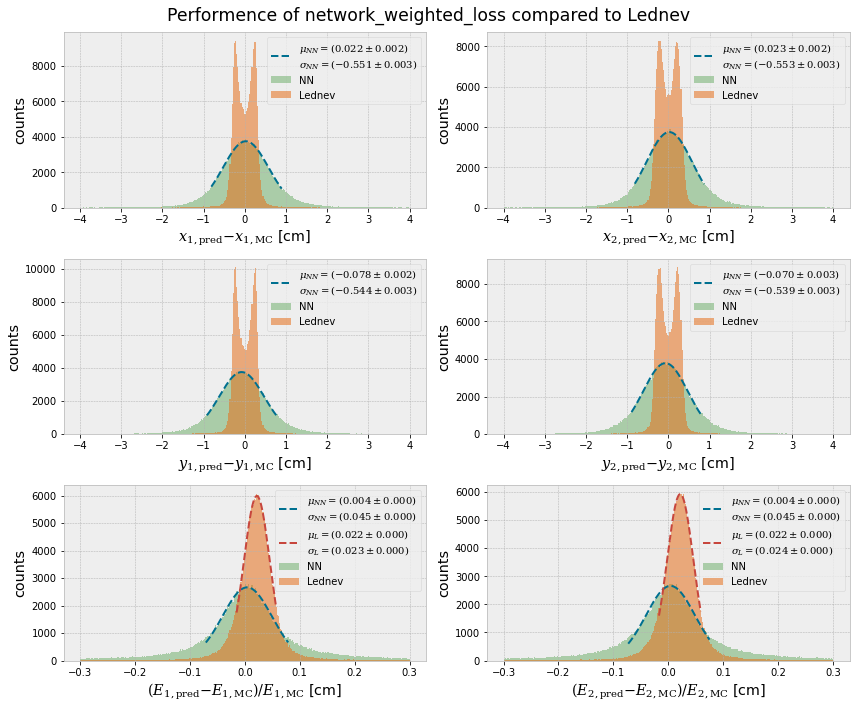

In [6]:
ev_fit_v_Lednev = ev.show_hist_NN_withLednev(figsave=(False, "network_weighted_loss"))

In [7]:
print(len(ev.x1), len(ev.x1_c))
print(len(np.where(ipd.x_fit_veri.T[0].T==-1000)[0]))

210514 210514
12285


In [8]:
print(ipd.x_fit_veri.T[0].T[9])

-1000.0


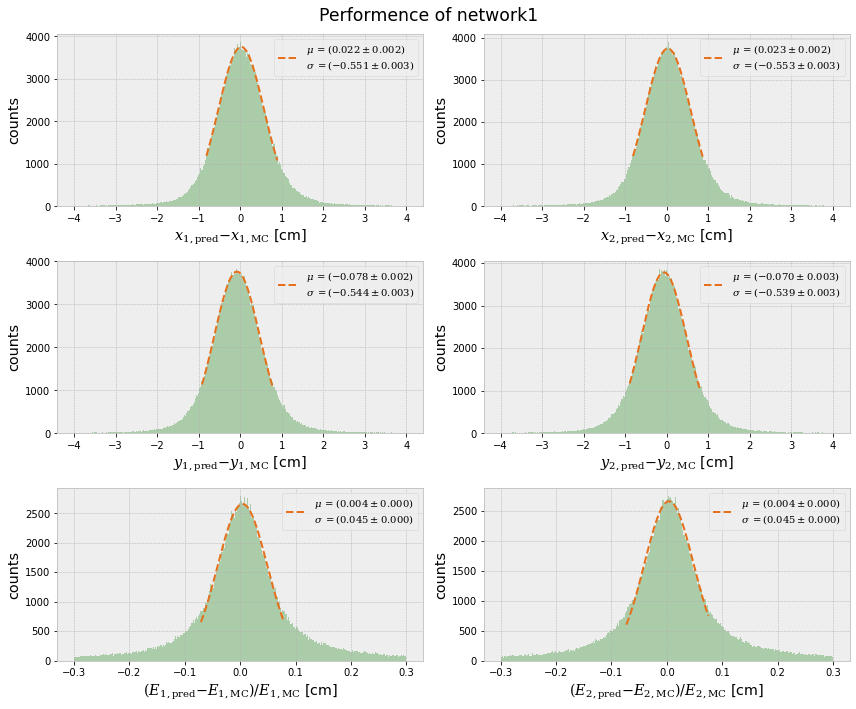

In [11]:
fit_param = ev.show_hist_NN()

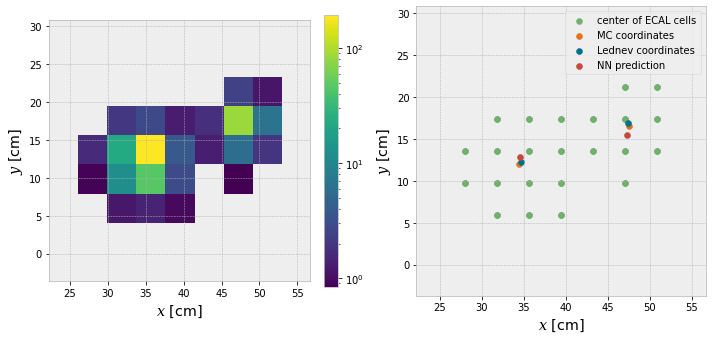

0


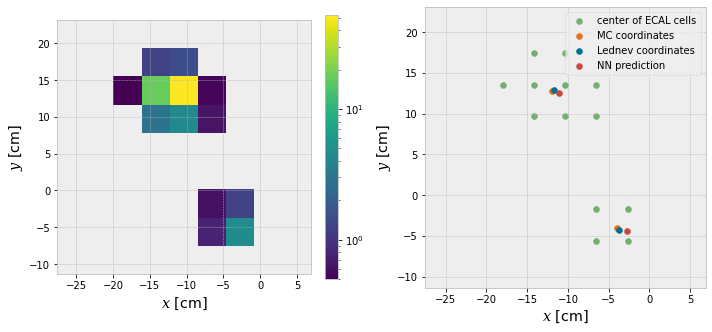

1


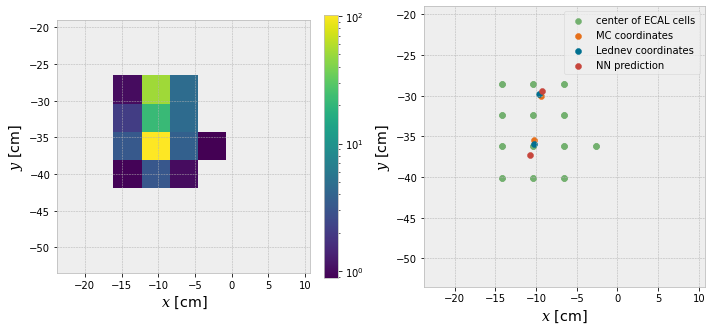

2


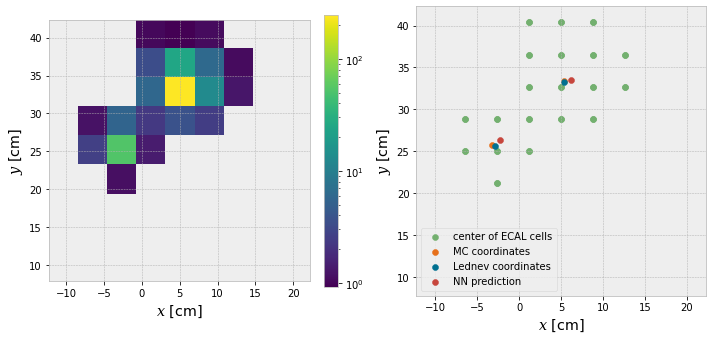

3


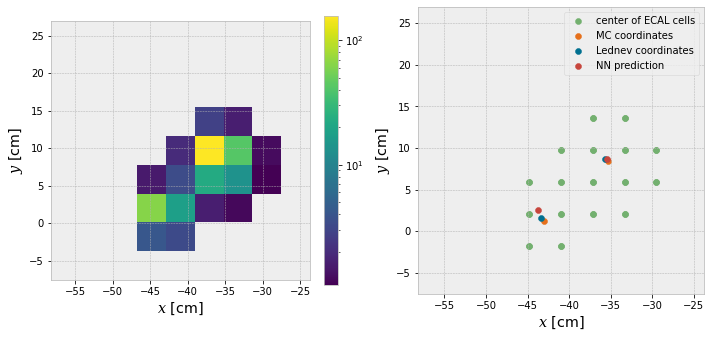

4


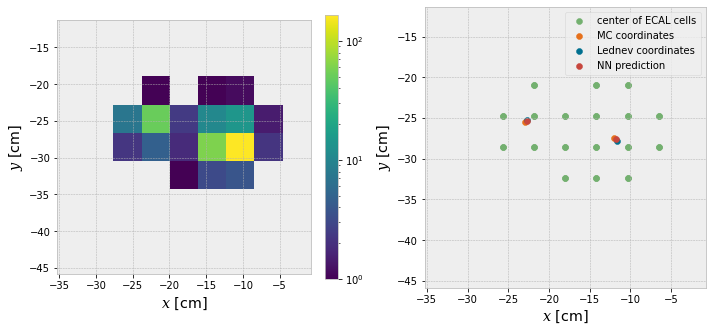

5


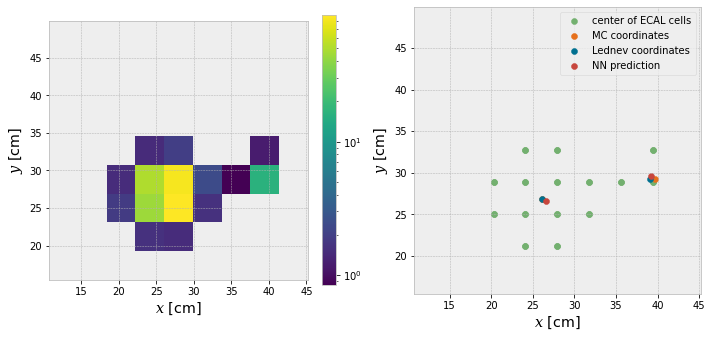

6


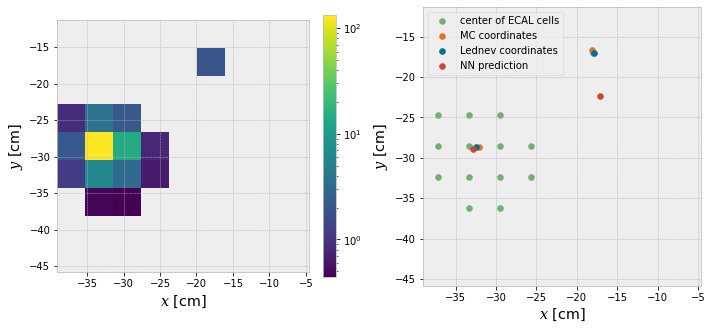

7


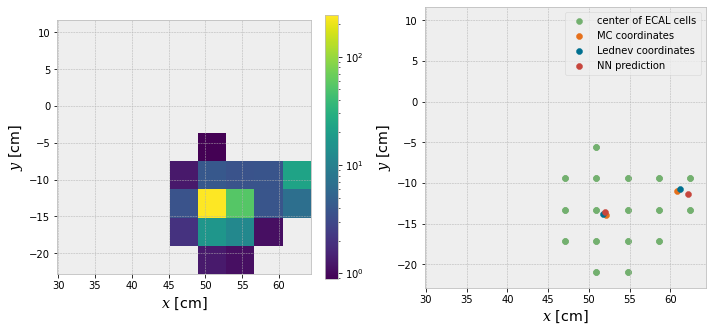

8


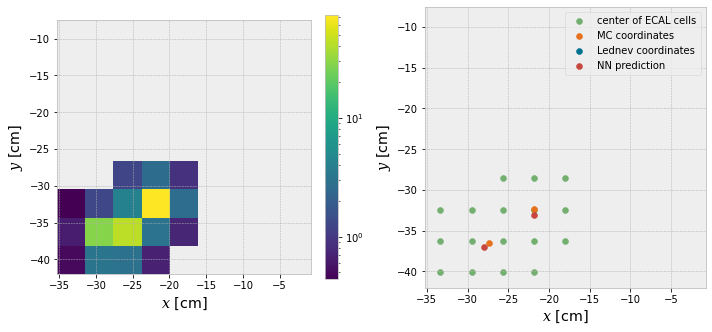

9


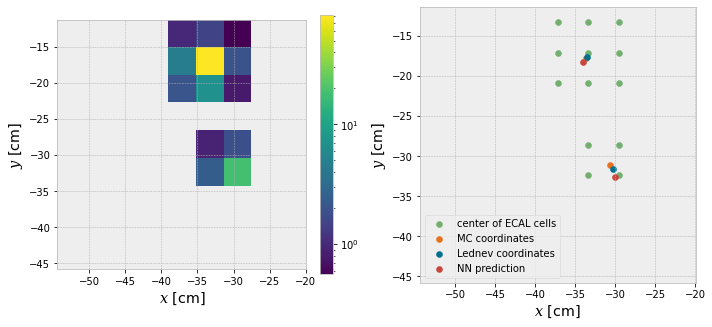

10


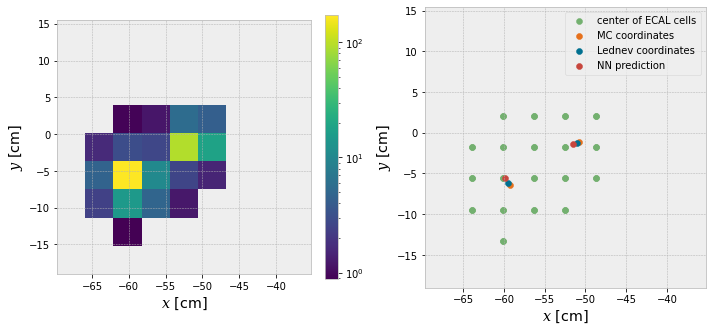

11


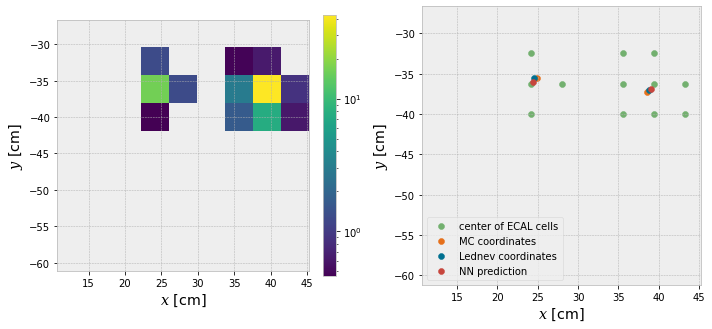

12


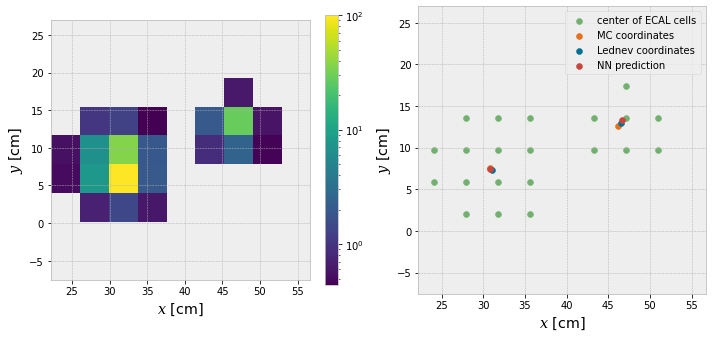

13


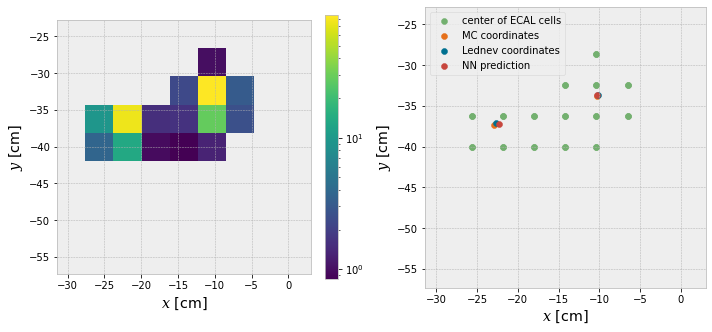

14


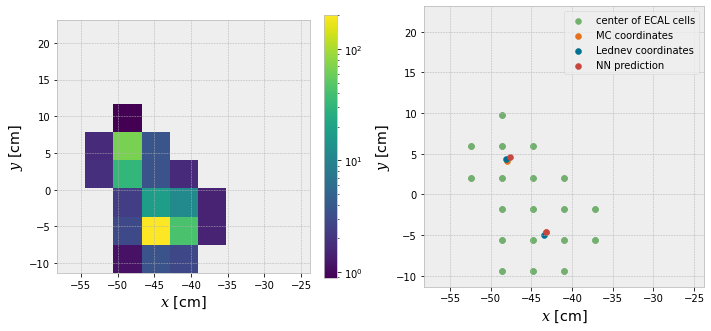

15


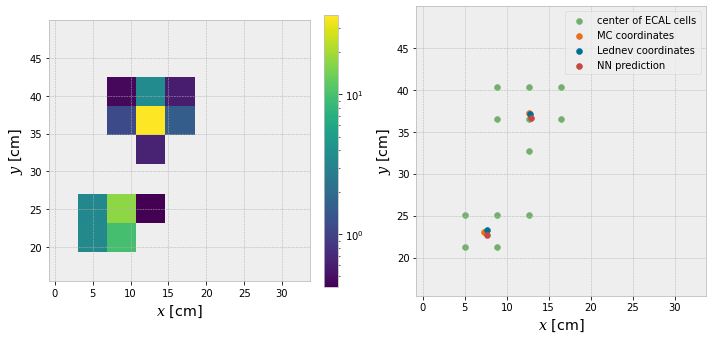

16


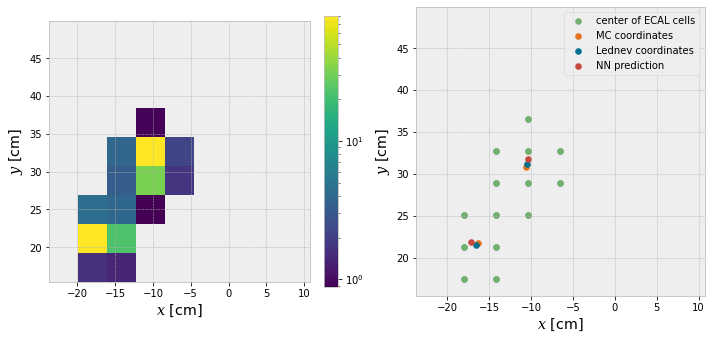

17


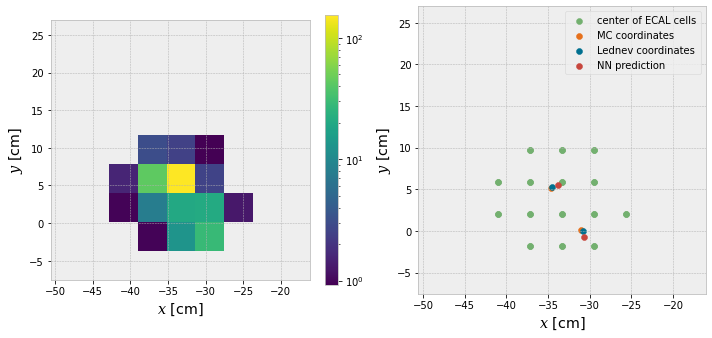

18


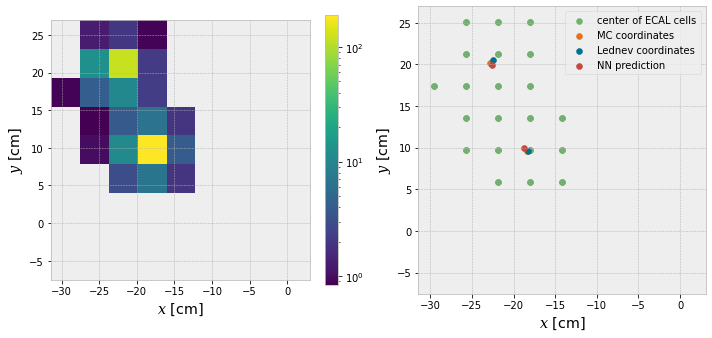

19


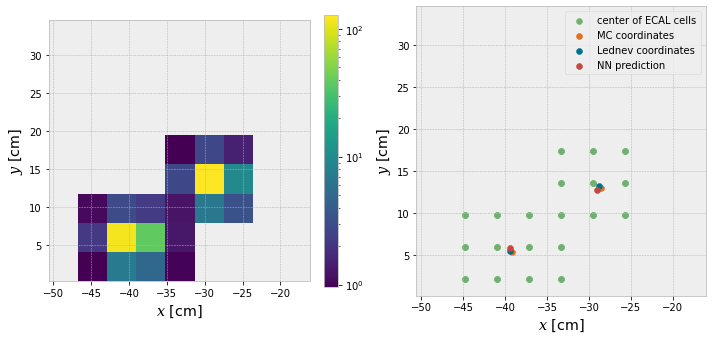

20


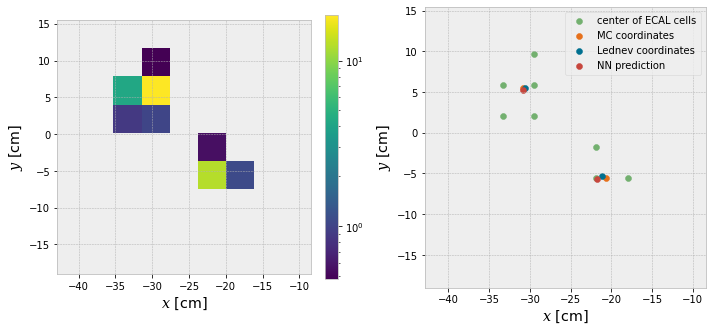

21


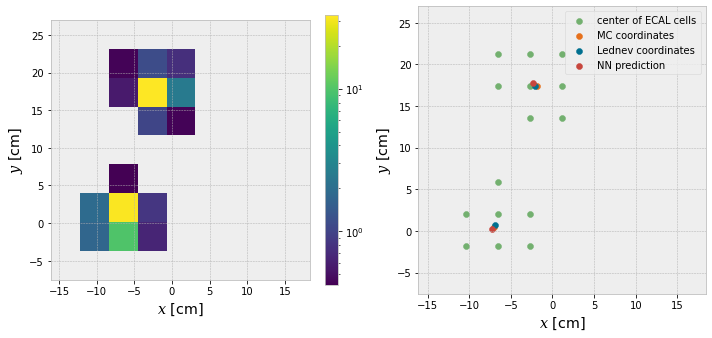

22


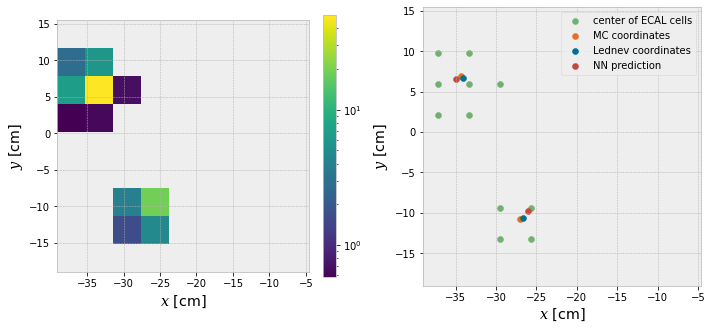

23


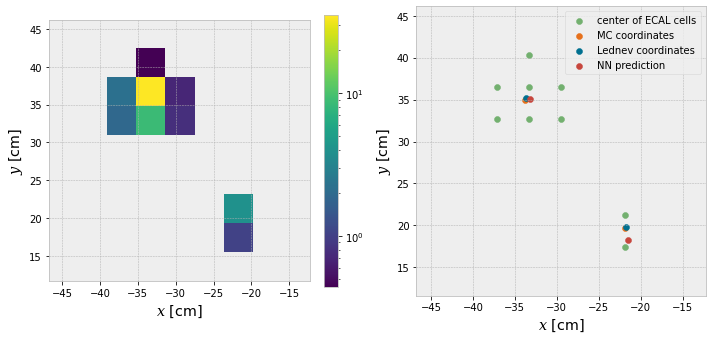

24


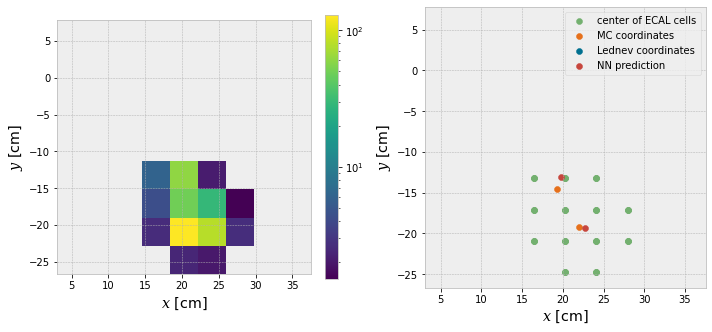

25


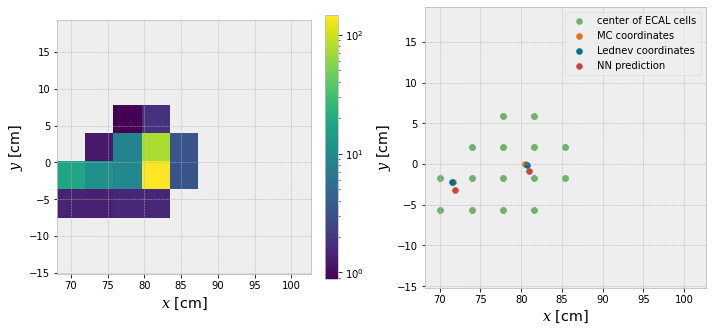

26


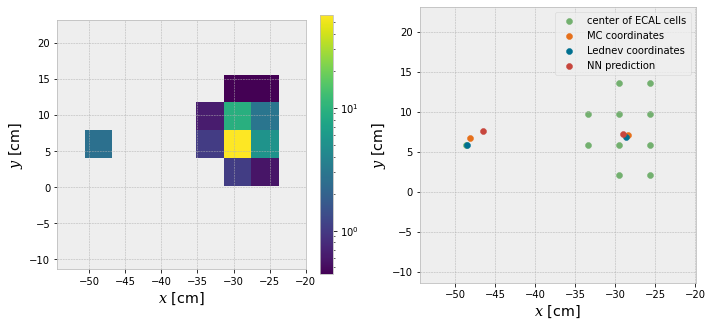

27


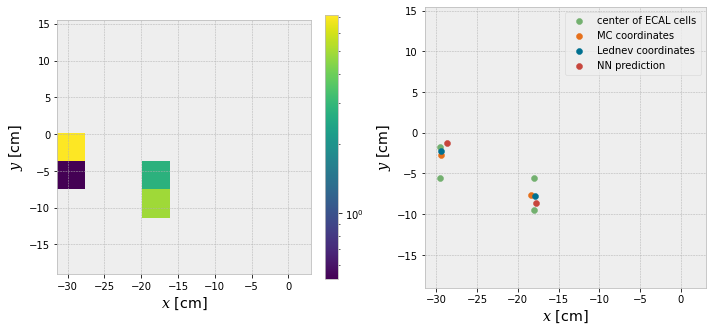

28


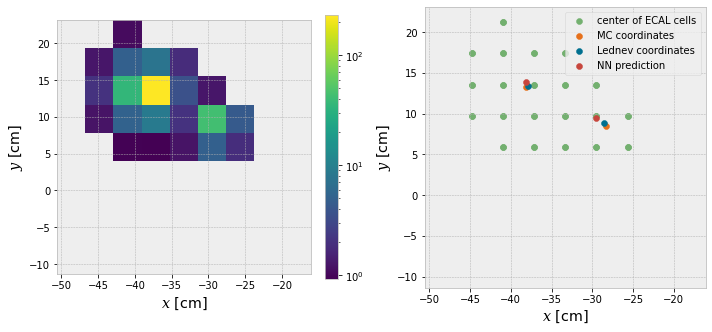

29


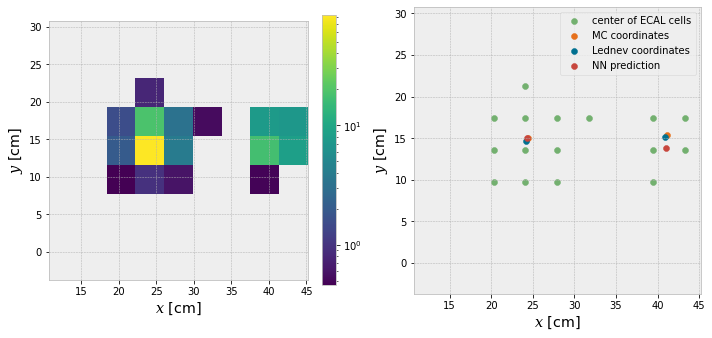

30


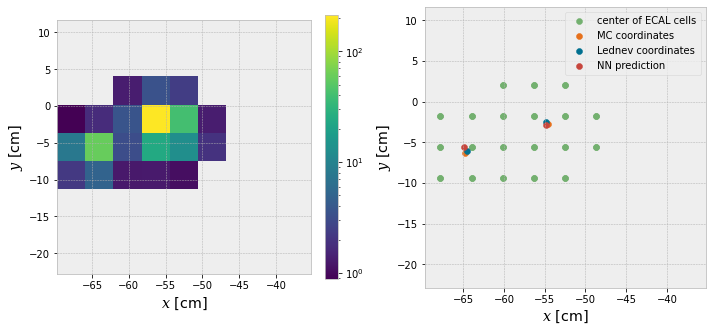

31


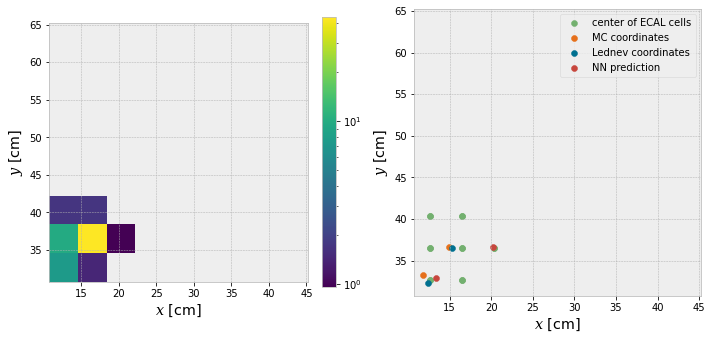

32


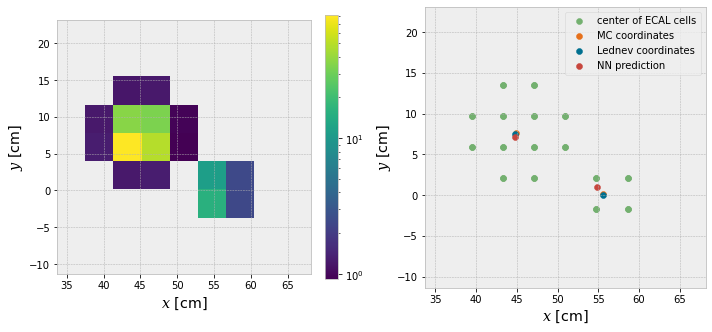

33


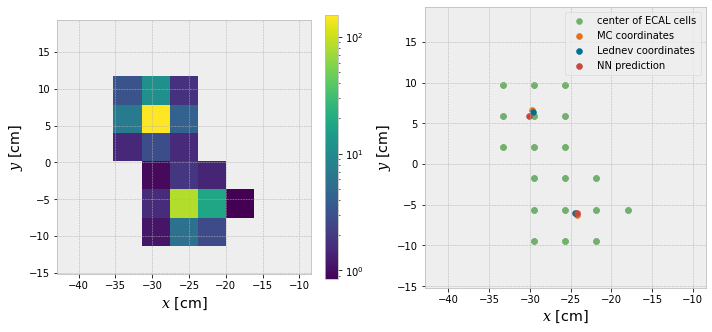

34


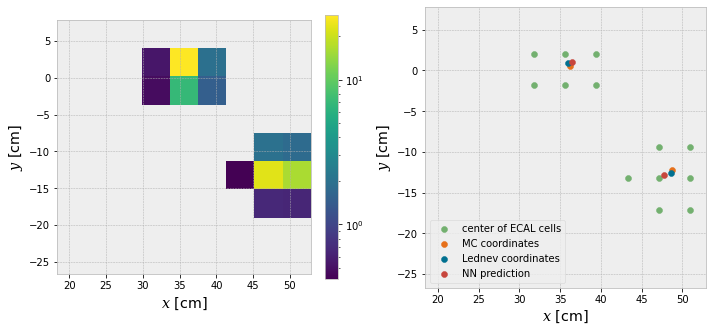

35


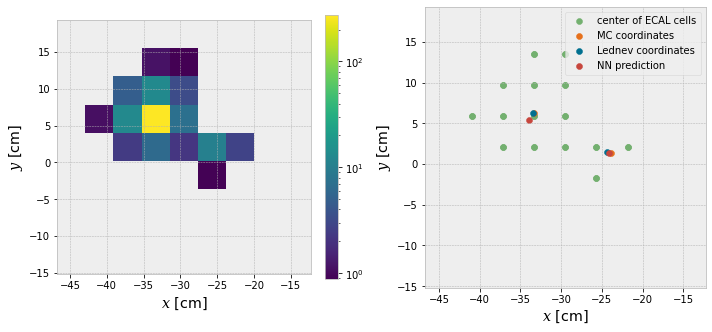

36


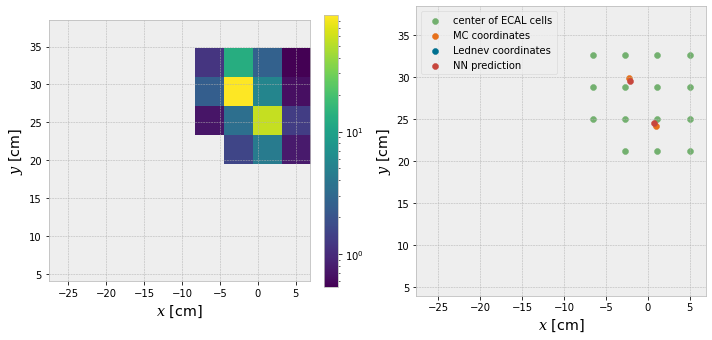

37


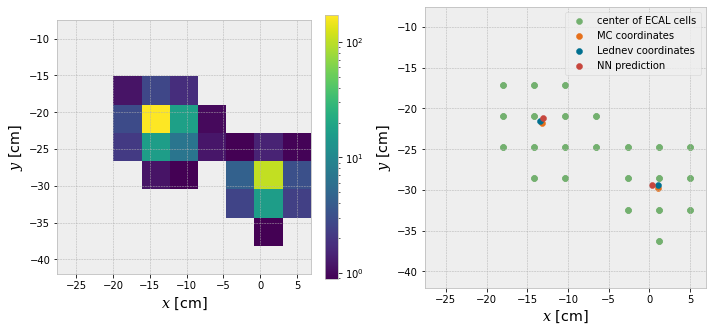

38


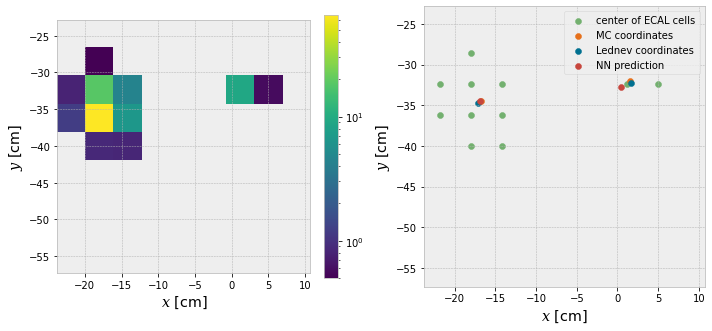

39


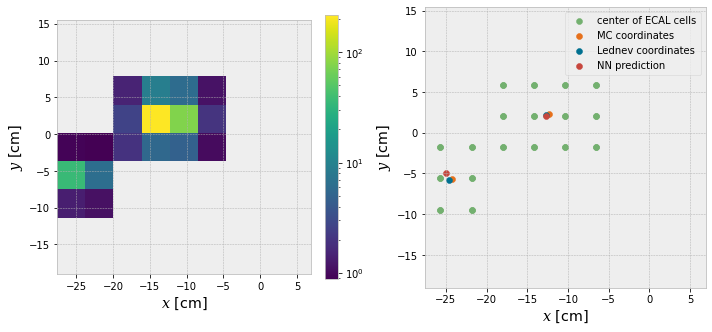

40


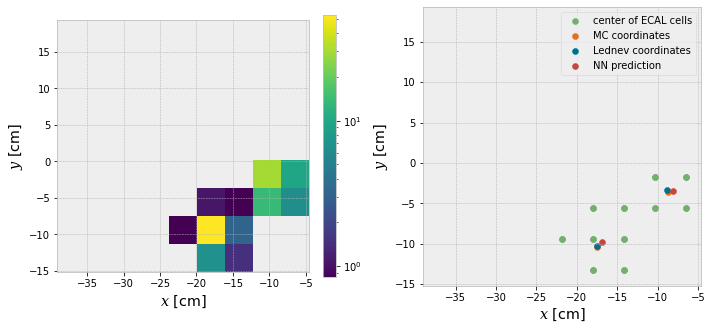

41


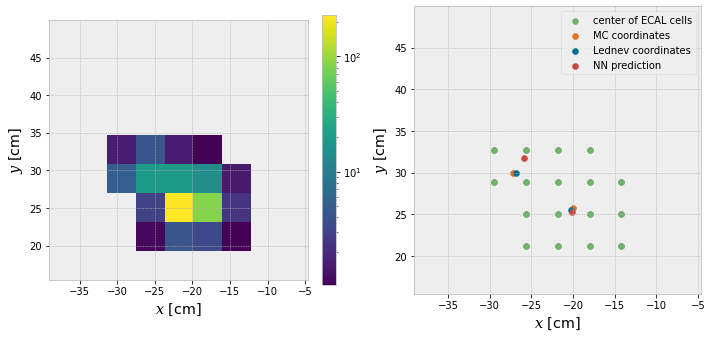

42


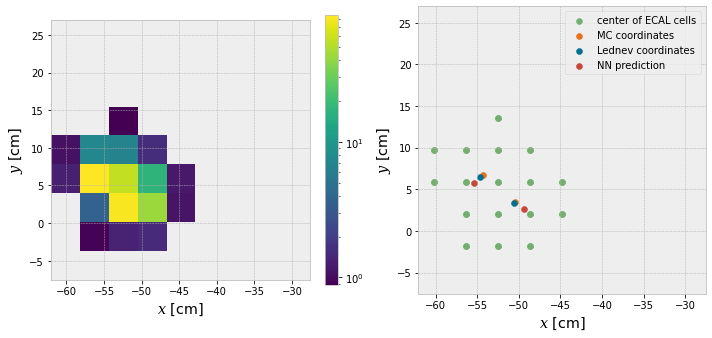

43


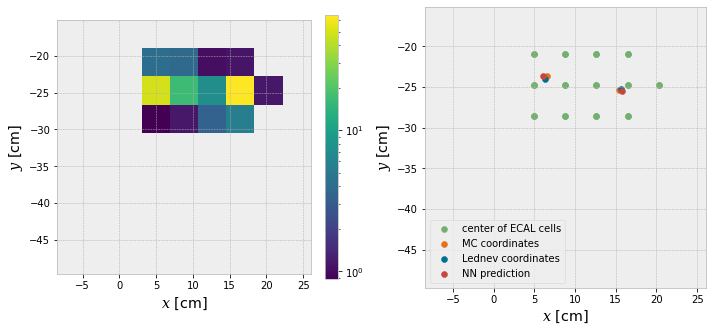

44


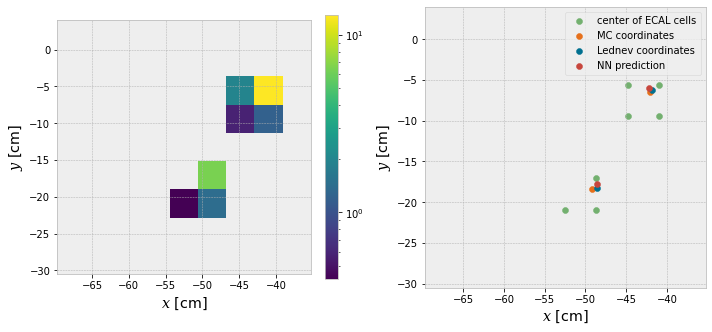

45


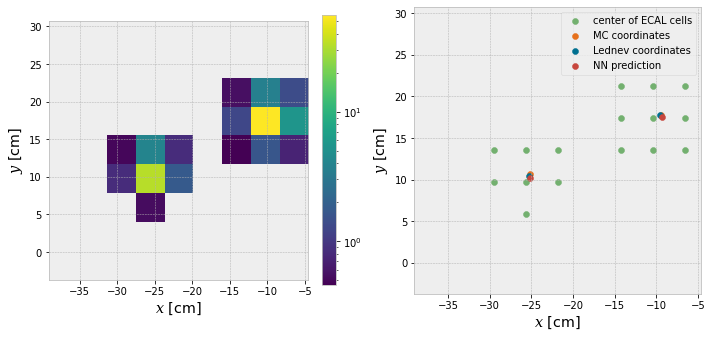

46


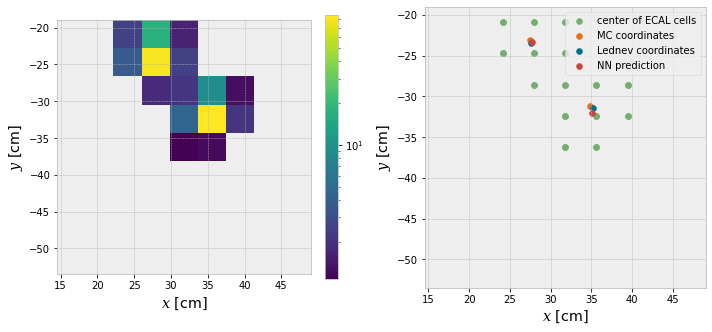

47


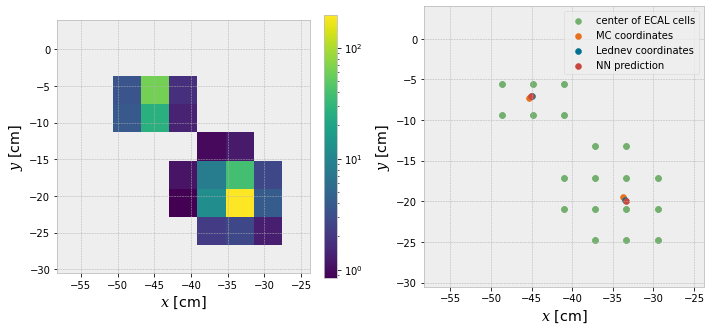

48


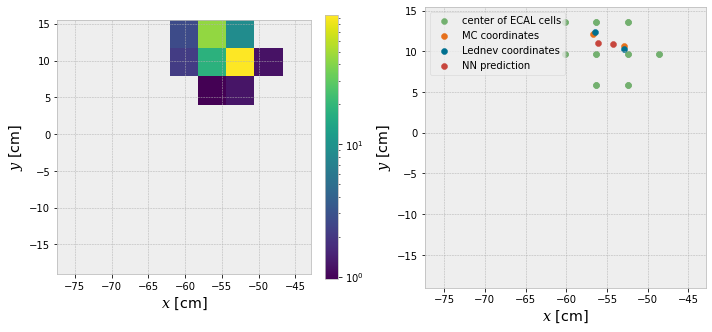

49


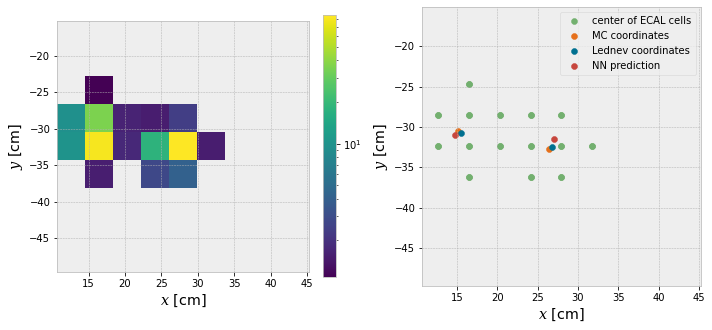

50


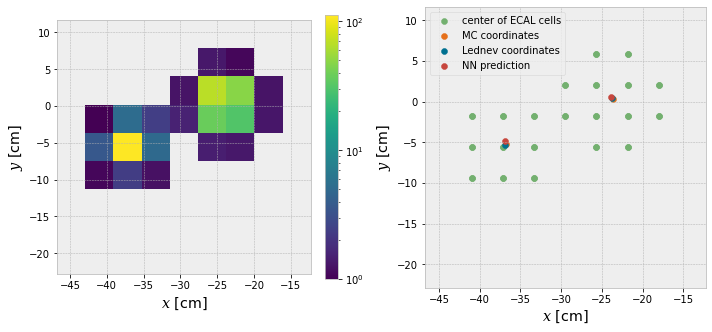

51


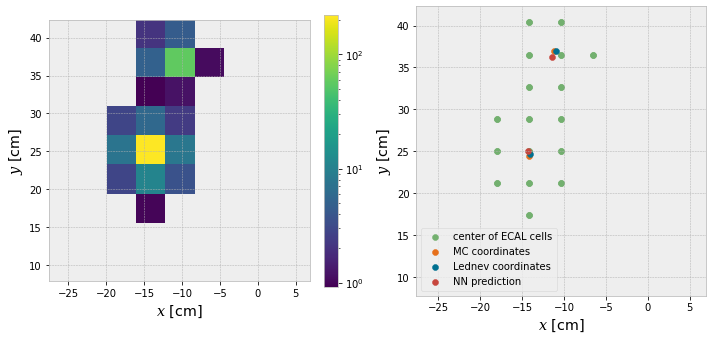

52


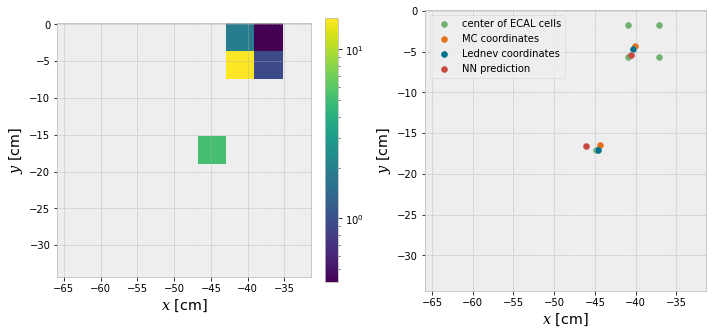

53


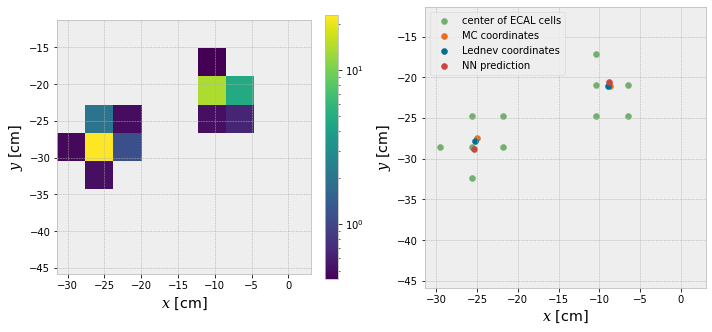

54


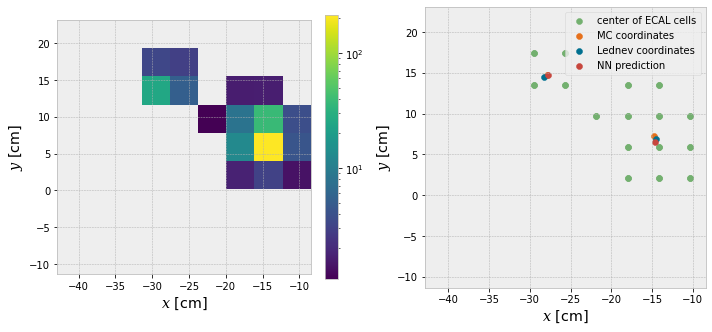

55


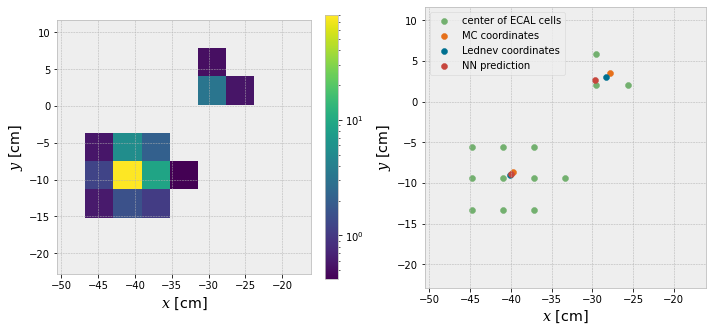

56


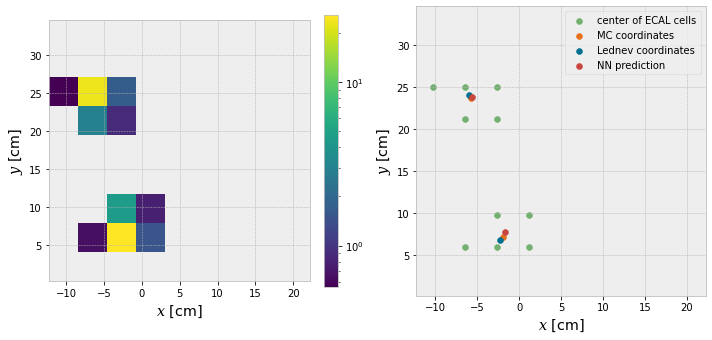

57


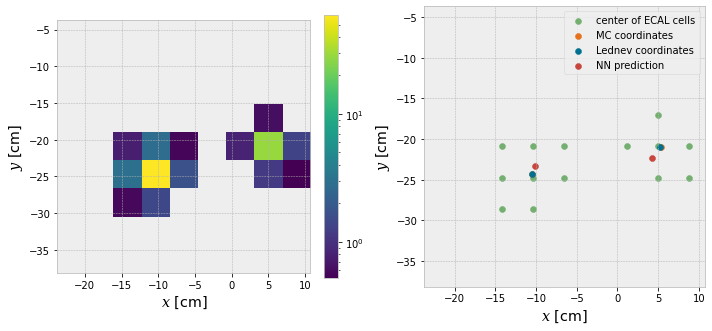

58


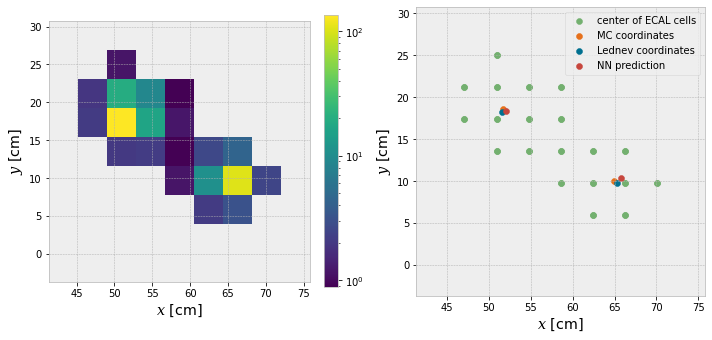

59


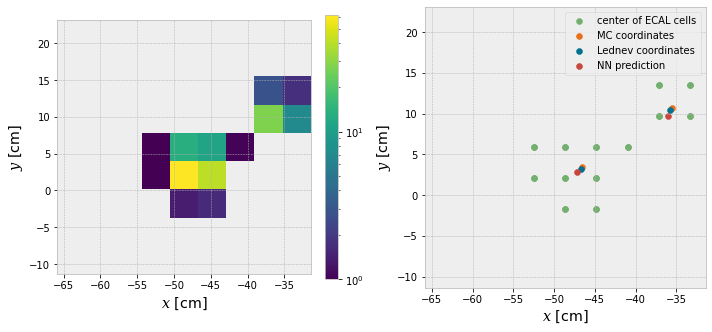

60


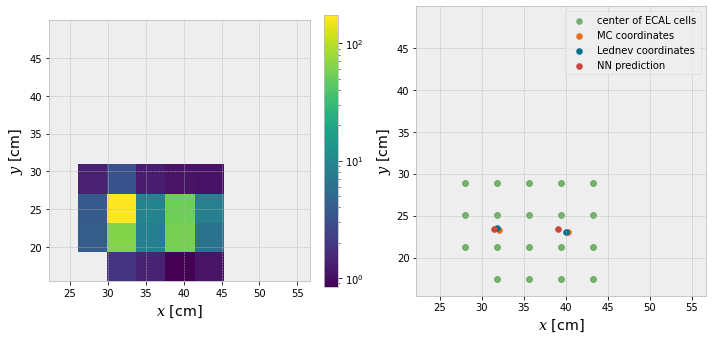

61


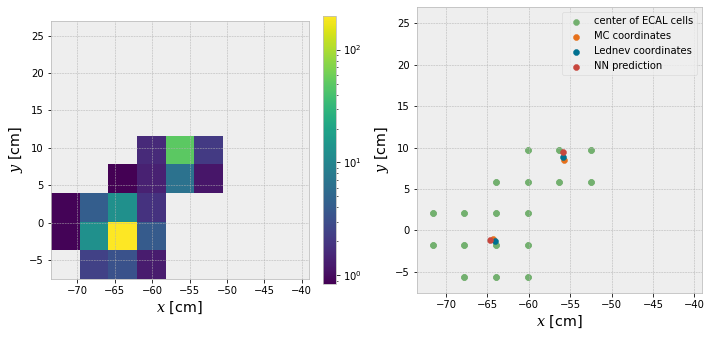

62


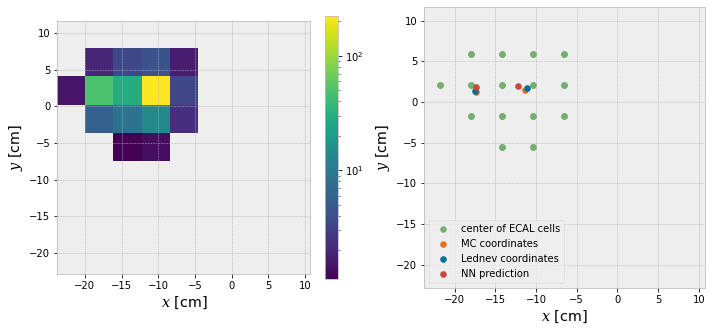

63


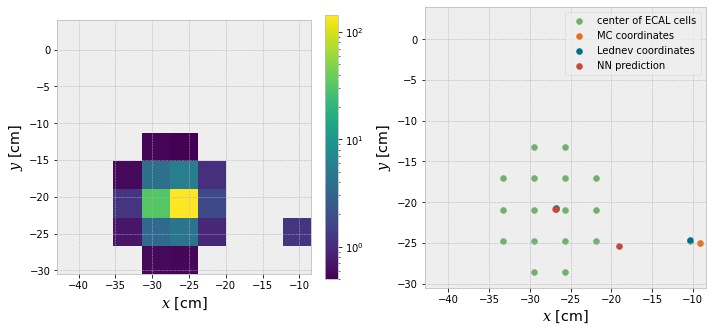

64


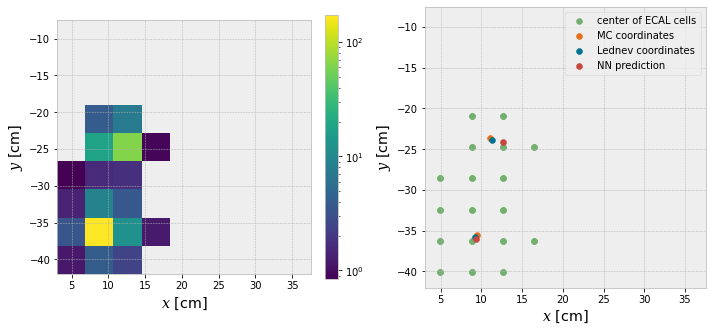

65


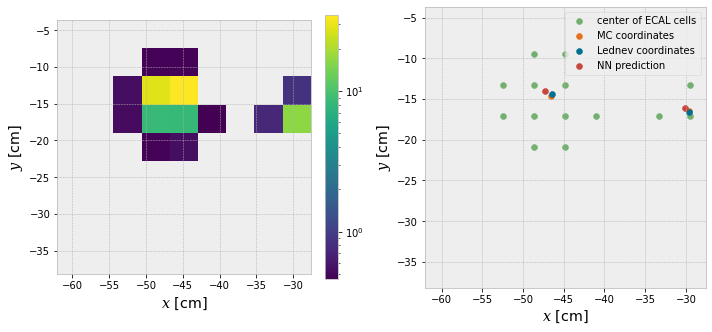

66


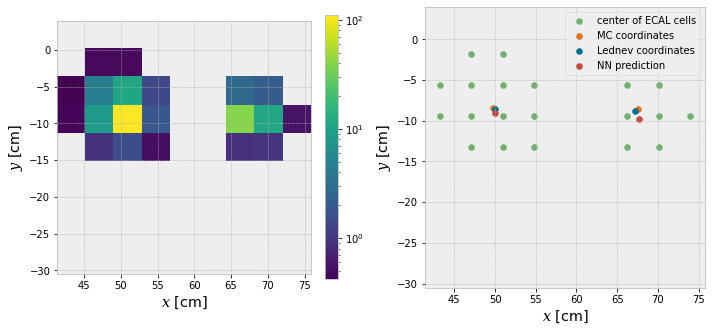

67


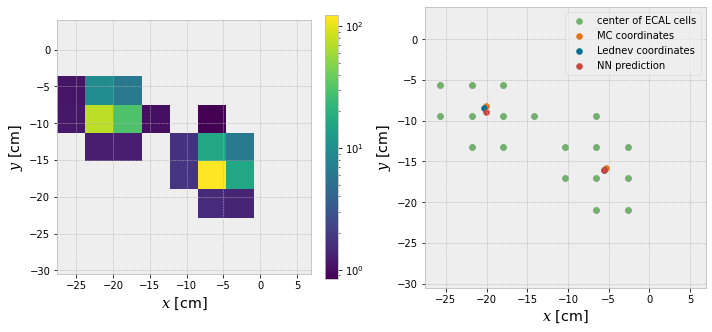

68


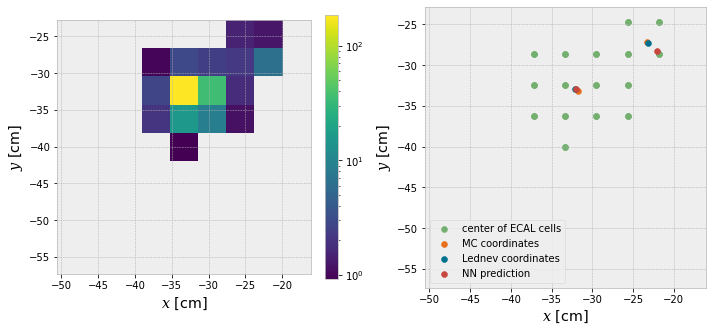

69


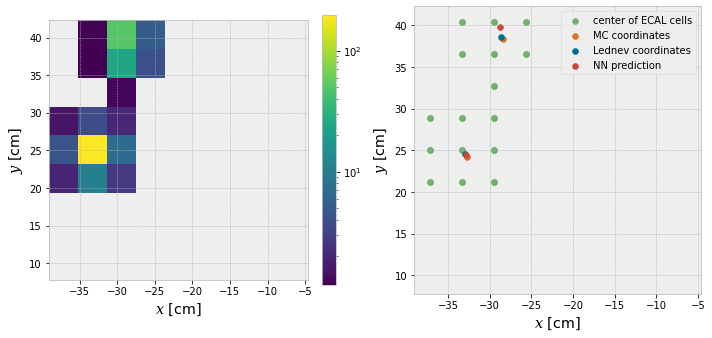

70


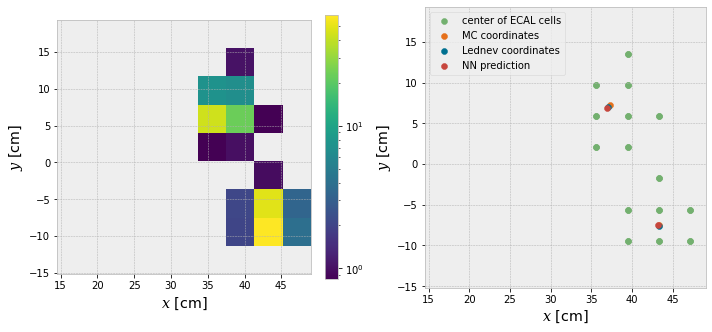

71


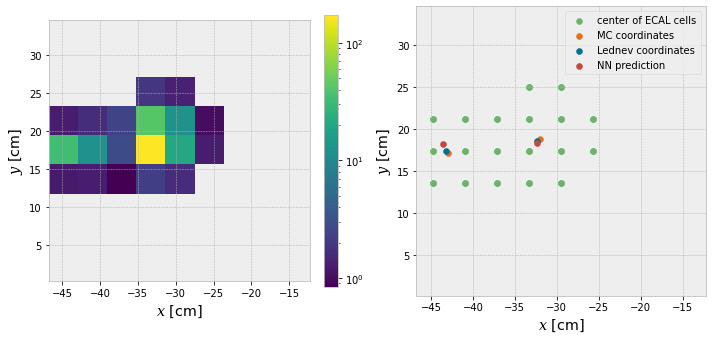

72


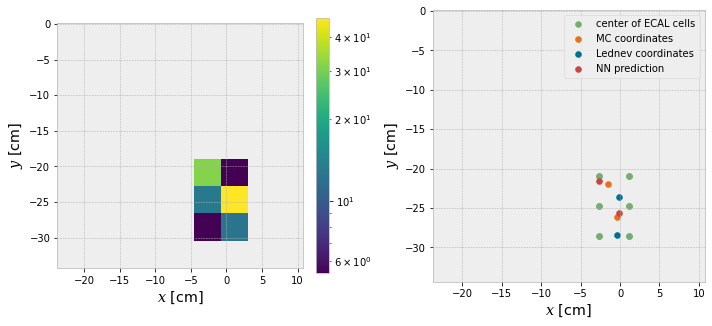

73


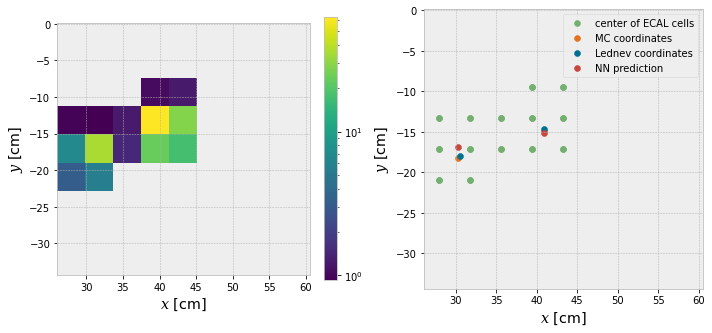

74


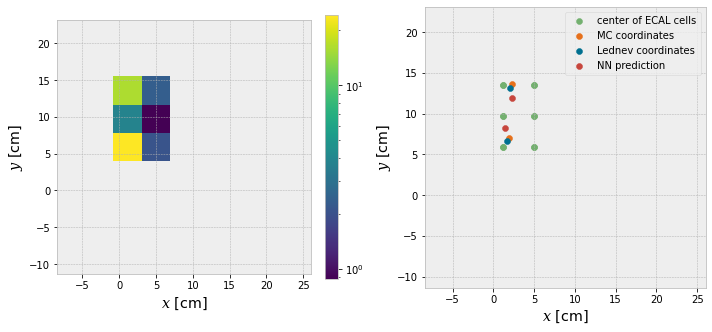

75


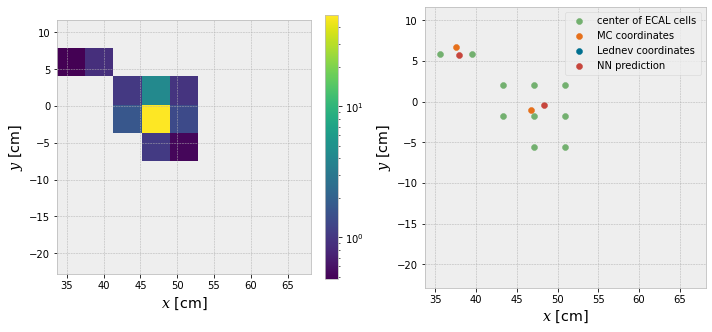

76


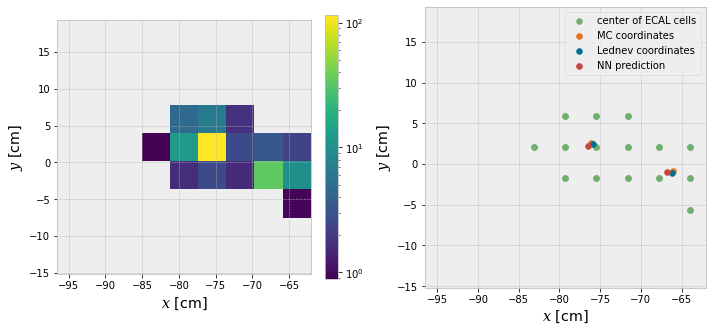

77


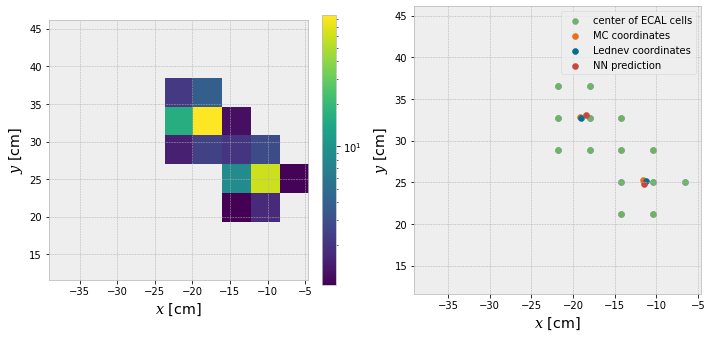

78


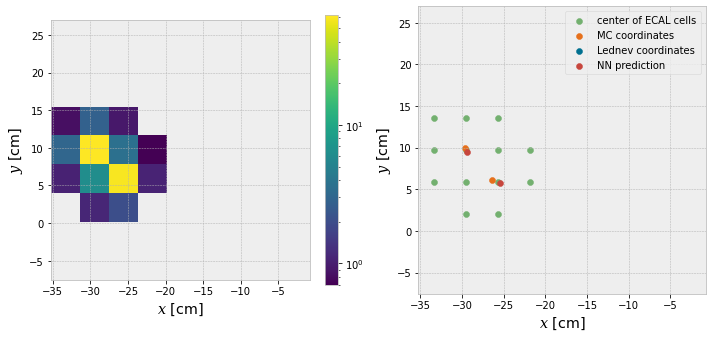

79


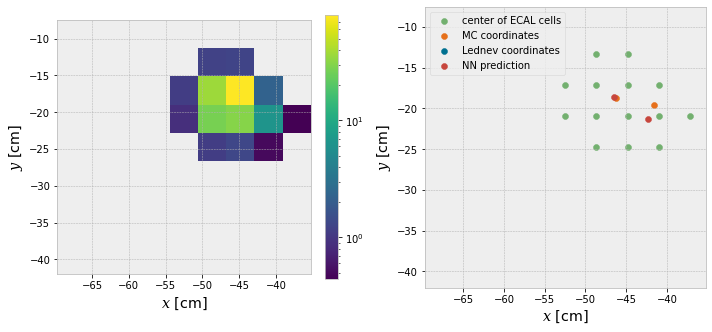

80


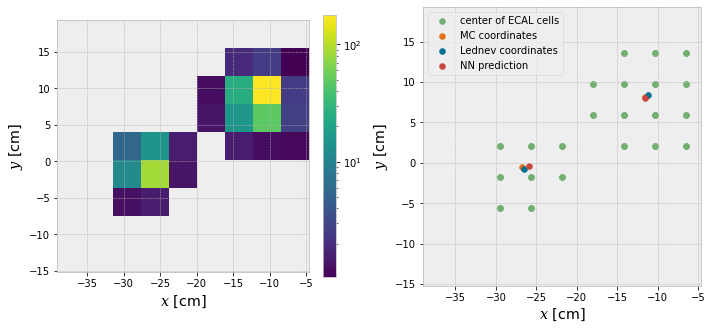

81


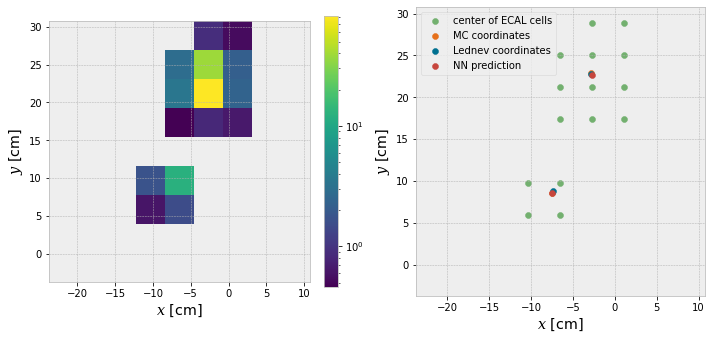

82


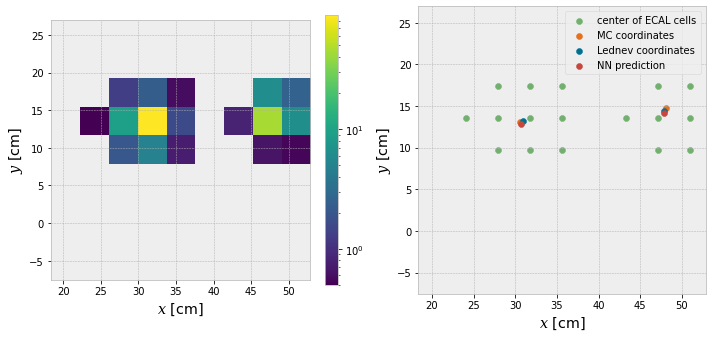

83


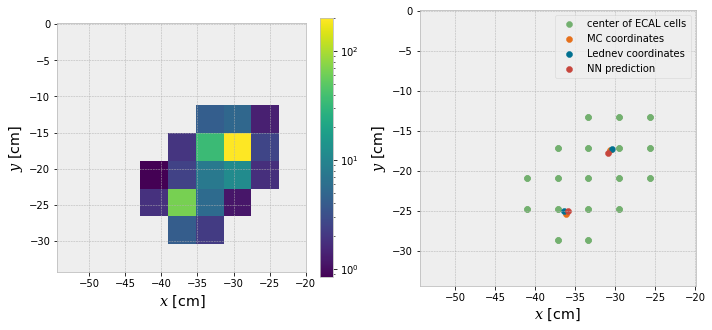

84


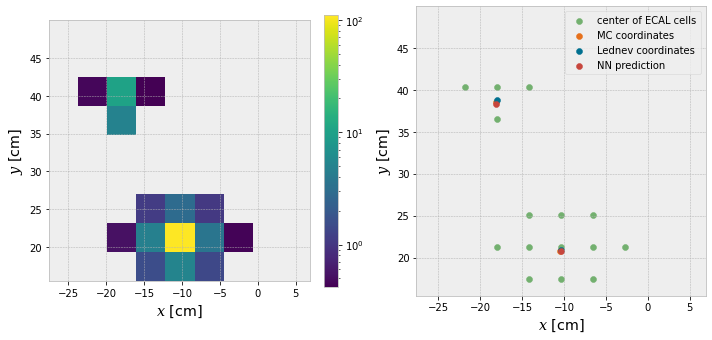

85


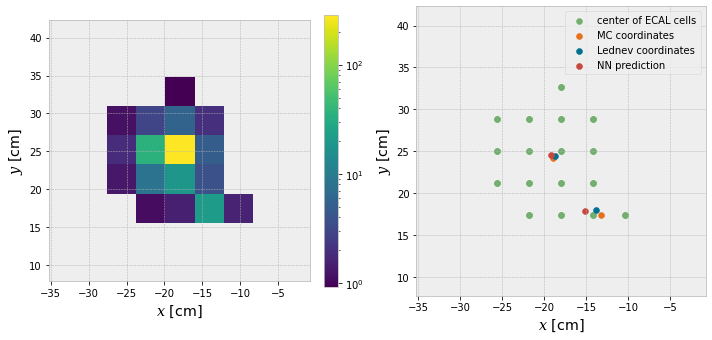

86


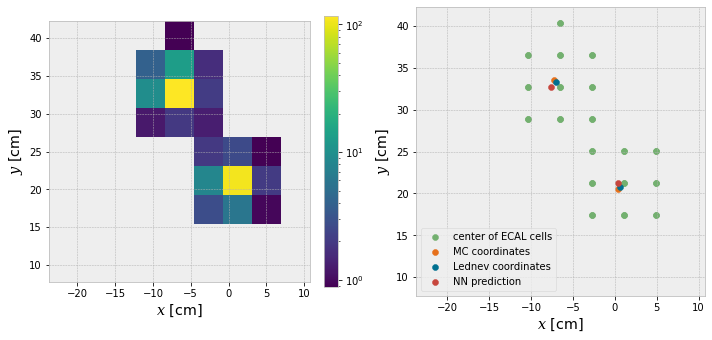

87


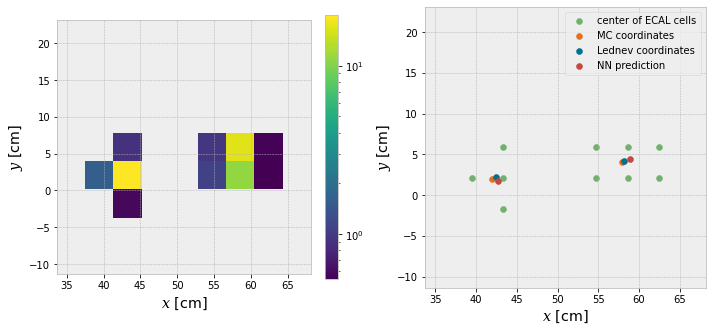

88


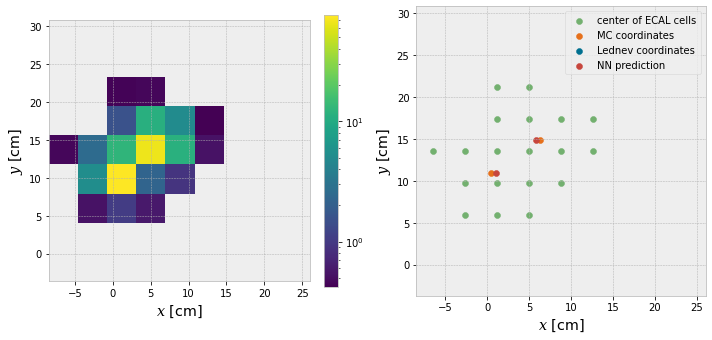

89


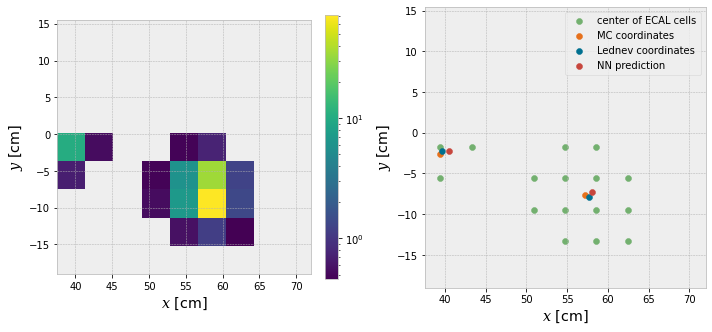

90


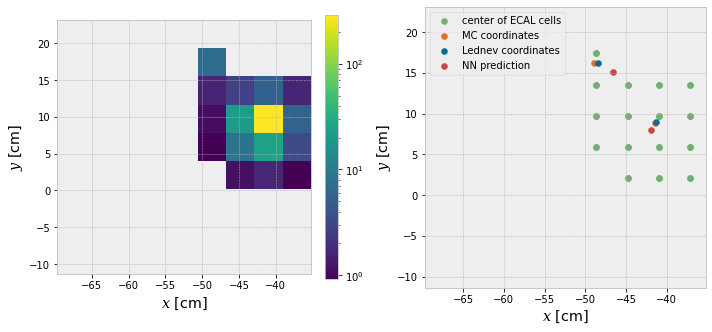

91


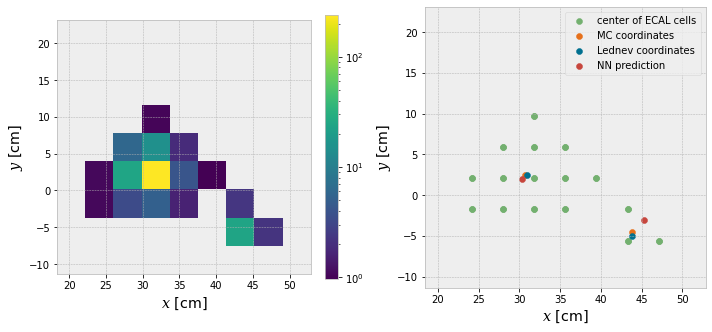

92


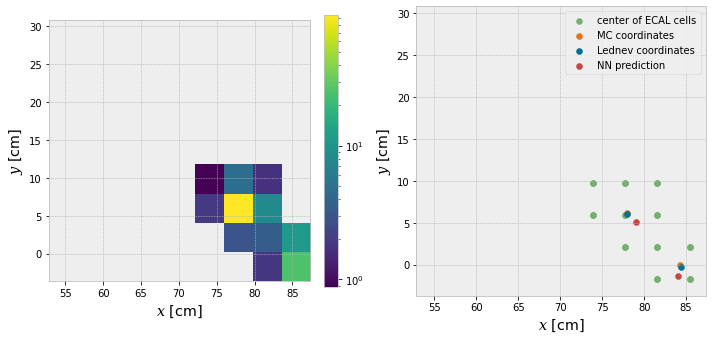

93


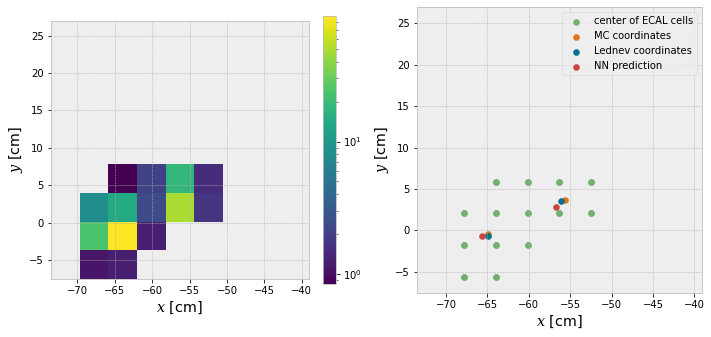

94


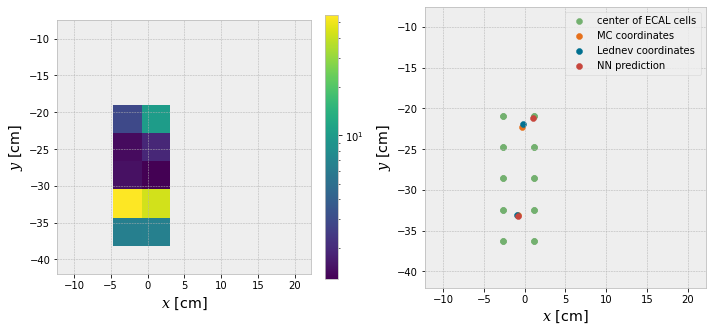

95


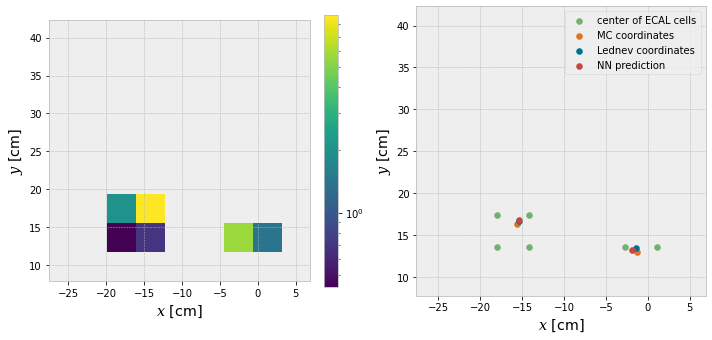

96


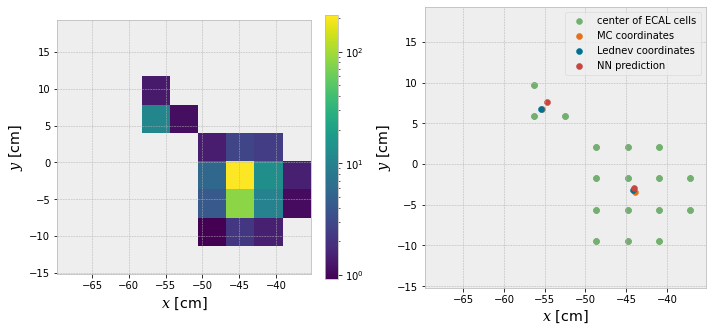

97


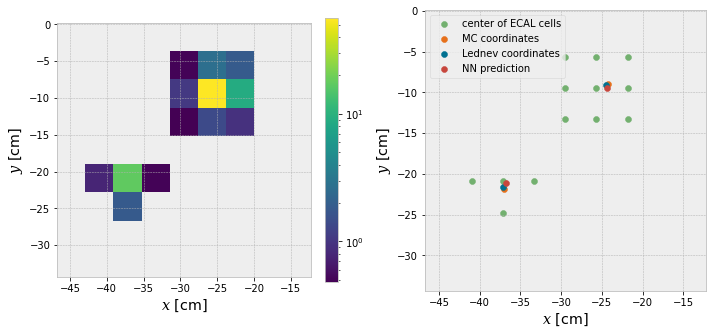

98


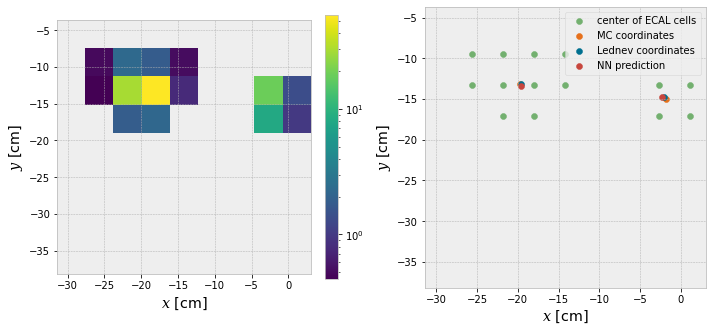

99


In [10]:
for i in range(100):
    ev.show_cluster_NNpred(i)
    print(i)

<h2> Do a bit of analysis... </h2>

In [13]:
from uncertainties import unumpy as unp

In [14]:
sig_x1 = unp.nominal_values(fit_param[1])
sig_x2 = unp.nominal_values(fit_param[3])
sig_y1 = unp.nominal_values(fit_param[5])
sig_y2 = unp.nominal_values(fit_param[7])
sig_E1 = unp.nominal_values(fit_param[9])
sig_E2 = unp.nominal_values(fit_param[11])

In [15]:
rel_E1 = (ev.E1 - ev.E1_t) / ev.E1_t
rel_E2 = (ev.E2 - ev.E2_t) / ev.E2_t

ind_E1_bad = np.where(abs(rel_E1) > abs(sig_E1))
ind_E2_bad = np.where(abs(rel_E2) > abs(sig_E2))
print(len(ind_E1_bad[0]), len(ind_E2_bad[0]))

109529 110188


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


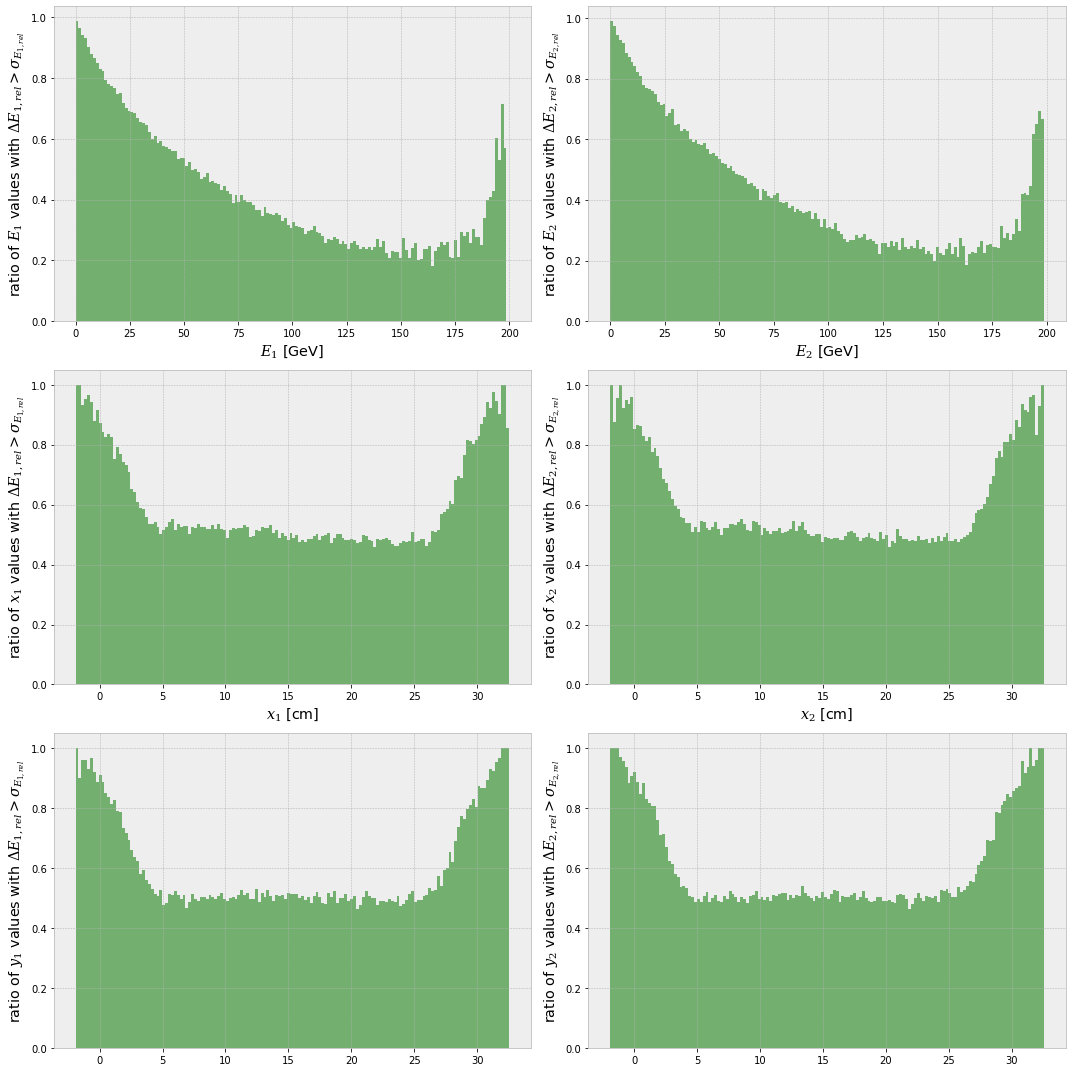

In [18]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_E1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_E1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_E1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_E2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_E2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_E2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.tight_layout()
plt.show()

<h2> Now the same but for $x$ values that are more than one $\sigma$ away.

In [19]:
diff_x1 = (ev.x1 - ev.x1_t) 
diff_x2 = (ev.x2 - ev.x2_t) 

ind_x1_bad = np.where(abs(diff_x1) > abs(sig_x1))
ind_x2_bad = np.where(abs(diff_x2) > abs(sig_x2))
print(len(ind_x1_bad[0]), len(ind_x2_bad[0]))

78144 77533


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


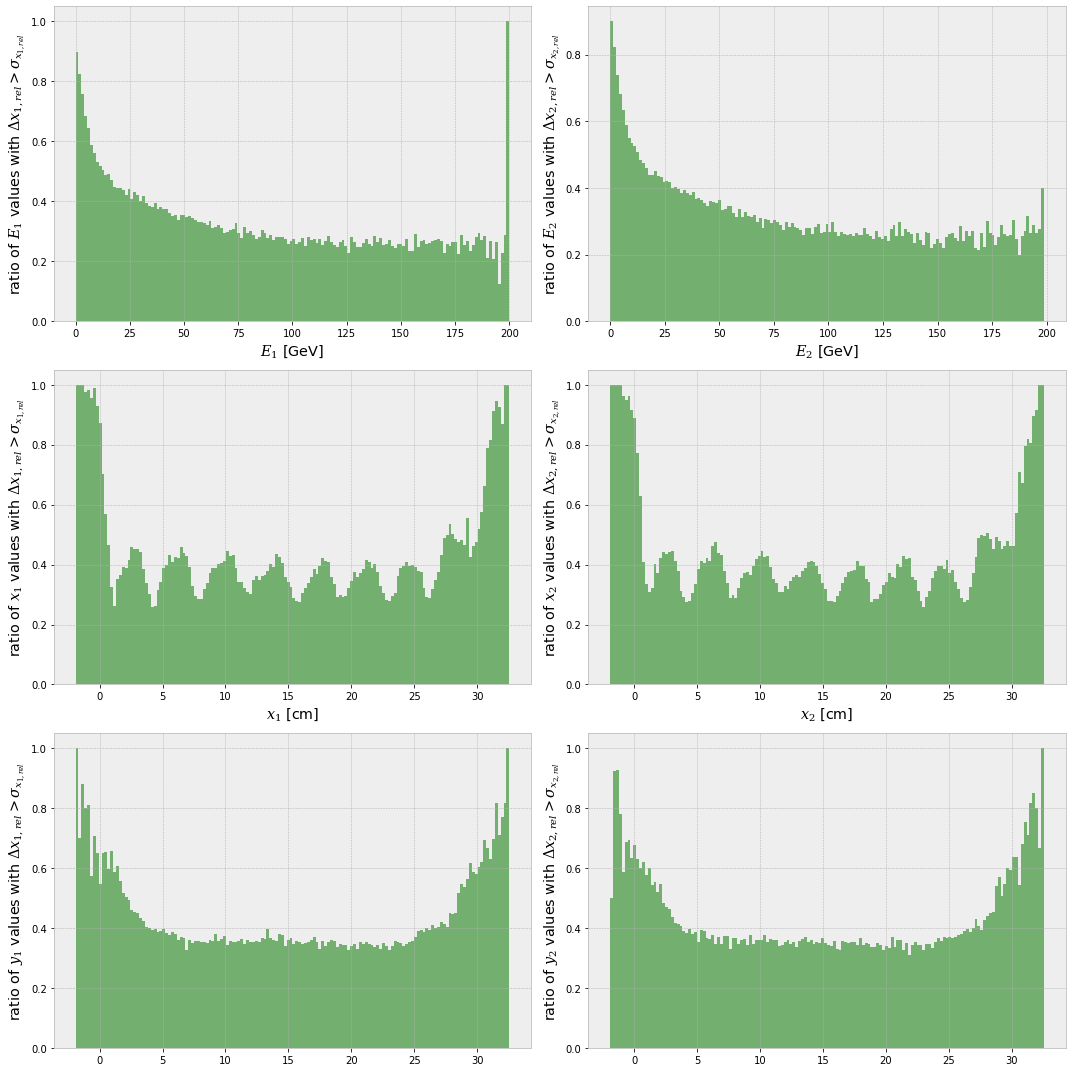

In [20]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_x1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_x1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_x1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta x_{1, rel} > \sigma_{x_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_x2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_x2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_x2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta x_{2, rel} > \sigma_{x_{2, rel}} $")

plt.tight_layout()
plt.show()

<h2> Now the same but for $y$ values that are more than one $\sigma$ away.

In [21]:
diff_y1 = (ev.y1 - ev.y1_t) 
diff_y2 = (ev.y2 - ev.y2_t) 

ind_y1_bad = np.where(abs(diff_y1) > abs(sig_y1))
ind_y2_bad = np.where(abs(diff_y2) > abs(sig_y2))
print(len(ind_y1_bad[0]), len(ind_y2_bad[0]))

80136 81240


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


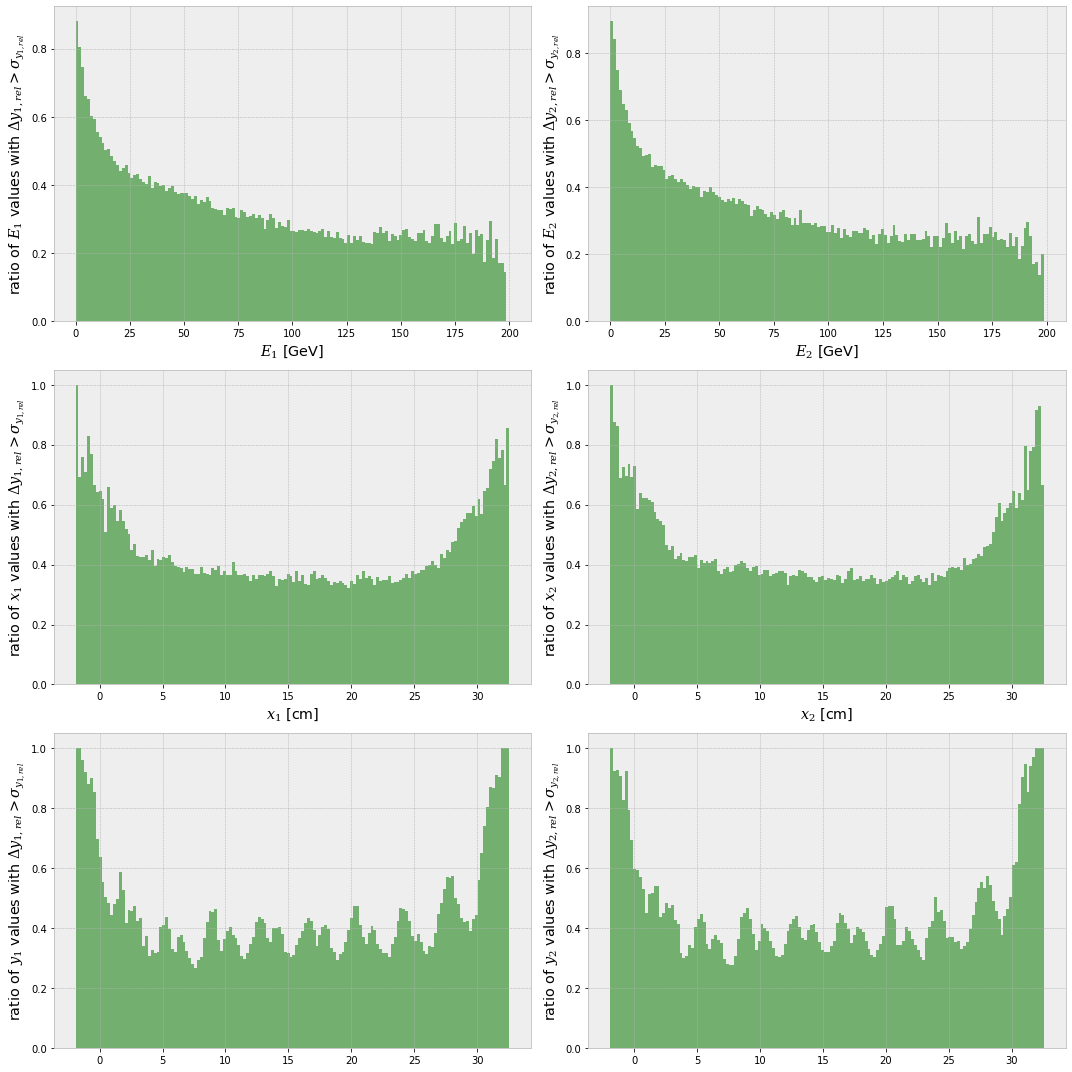

In [22]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(ev.E1_t, bins=b, range=(0, 200))
hist_E1_bad, bins = np.histogram(ev.E1_t[ind_y1_bad], bins=b, range=(0, 200))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel("$E_1 $ [GeV]")
plt.ylabel("ratio of $E_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(ev.x1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x1_bad, bins = np.histogram(ev.x1_t[ind_y1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel("$x_1 $ [cm]")
plt.ylabel("ratio of $x_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(ev.y1_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y1_bad, bins = np.histogram(ev.y1_t[ind_y1_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.ylabel("$y_1 $ [cm]")
plt.ylabel("ratio of $y_1$ values with $\Delta y_{1, rel} > \sigma_{y_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(ev.E2_t, bins=b, range=(0, 200))
hist_E2_bad, bins = np.histogram(ev.E2_t[ind_y2_bad], bins=b, range=(0, 200))
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel("$E_2 $ [GeV]")
plt.ylabel("ratio of $E_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(ev.x2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_x2_bad, bins = np.histogram(ev.x2_t[ind_y2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel("$x_2 $ [cm]")
plt.ylabel("ratio of $x_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(ev.y2_t, bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
hist_y2_bad, bins = np.histogram(ev.y2_t[ind_y2_bad], bins=b, range=(-ipd.cellsize/2, -ipd.cellsize/2 + 9*ipd.cellsize))
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.ylabel("$y_2 $ [cm]")
plt.ylabel("ratio of $y_2$ values with $\Delta y_{2, rel} > \sigma_{y_{2, rel}} $")

plt.tight_layout()
plt.show()

<h2> und Winkel?

In [23]:
# theta aus verification set...

theta_x1_t = np.arccos(ipd.momentum_v.T[0]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_y1_t = np.arccos(ipd.momentum_v.T[1]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_z1_t = np.arccos(ipd.momentum_v.T[2]/ (np.linalg.norm(ipd.momentum_v.T[:3].T, axis=1)))
theta_x2_t = np.arccos(ipd.momentum_v.T[0+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_y2_t = np.arccos(ipd.momentum_v.T[1+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))
theta_z2_t = np.arccos(ipd.momentum_v.T[2+3]/ (np.linalg.norm(ipd.momentum_v.T[3:].T, axis=1)))

/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


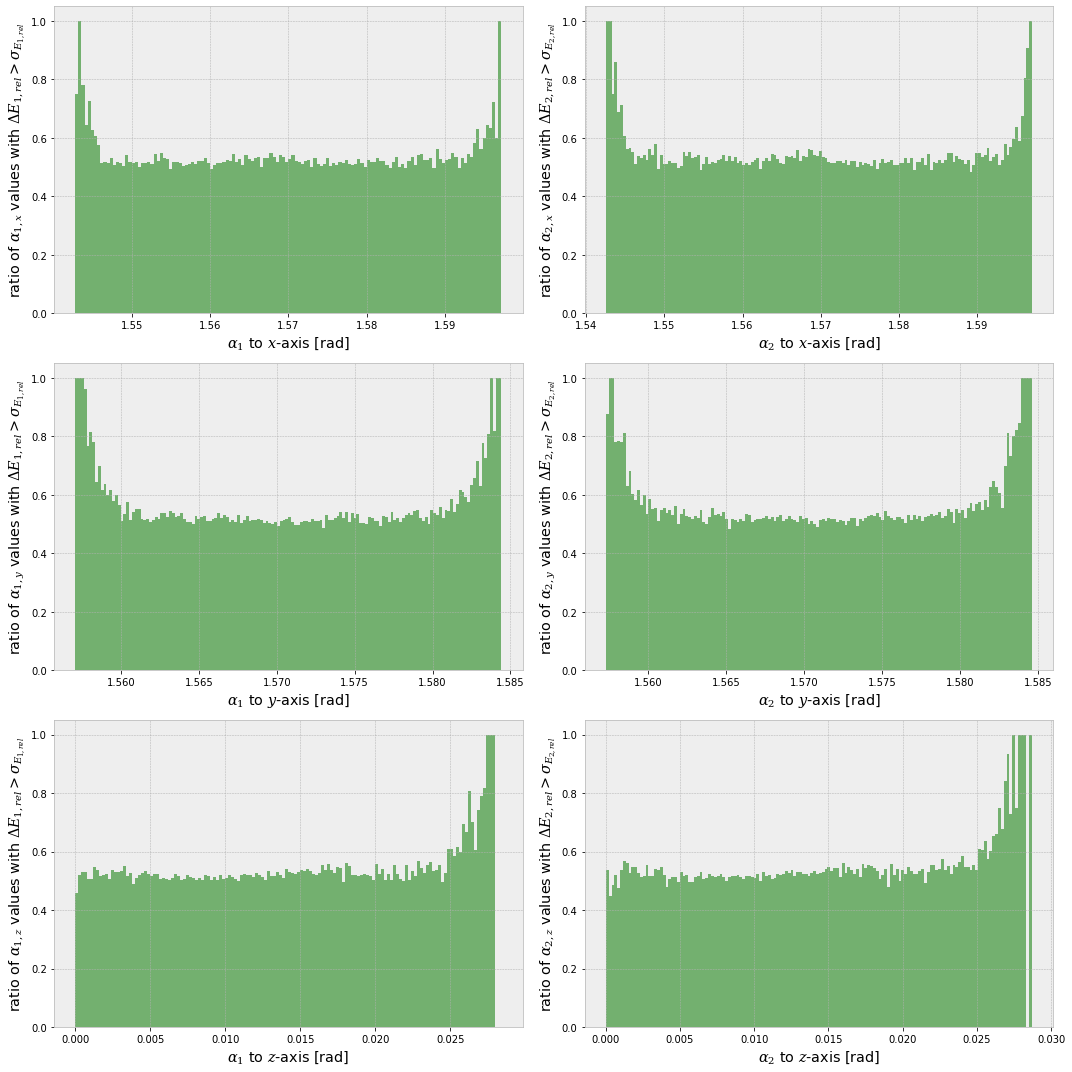

In [27]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b, range=(1.54,1.60))
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_E1_bad], bins=b, range=(1.54,1.60))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_E1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b, range=(0,0.03))
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_E1_bad], bins=b, range=(0,0.03))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta E_{1, rel} > \sigma_{E_{1, rel}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_E2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_E2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_E2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta E_{2, rel} > \sigma_{E_{2, rel}} $")

plt.tight_layout()
plt.show()


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


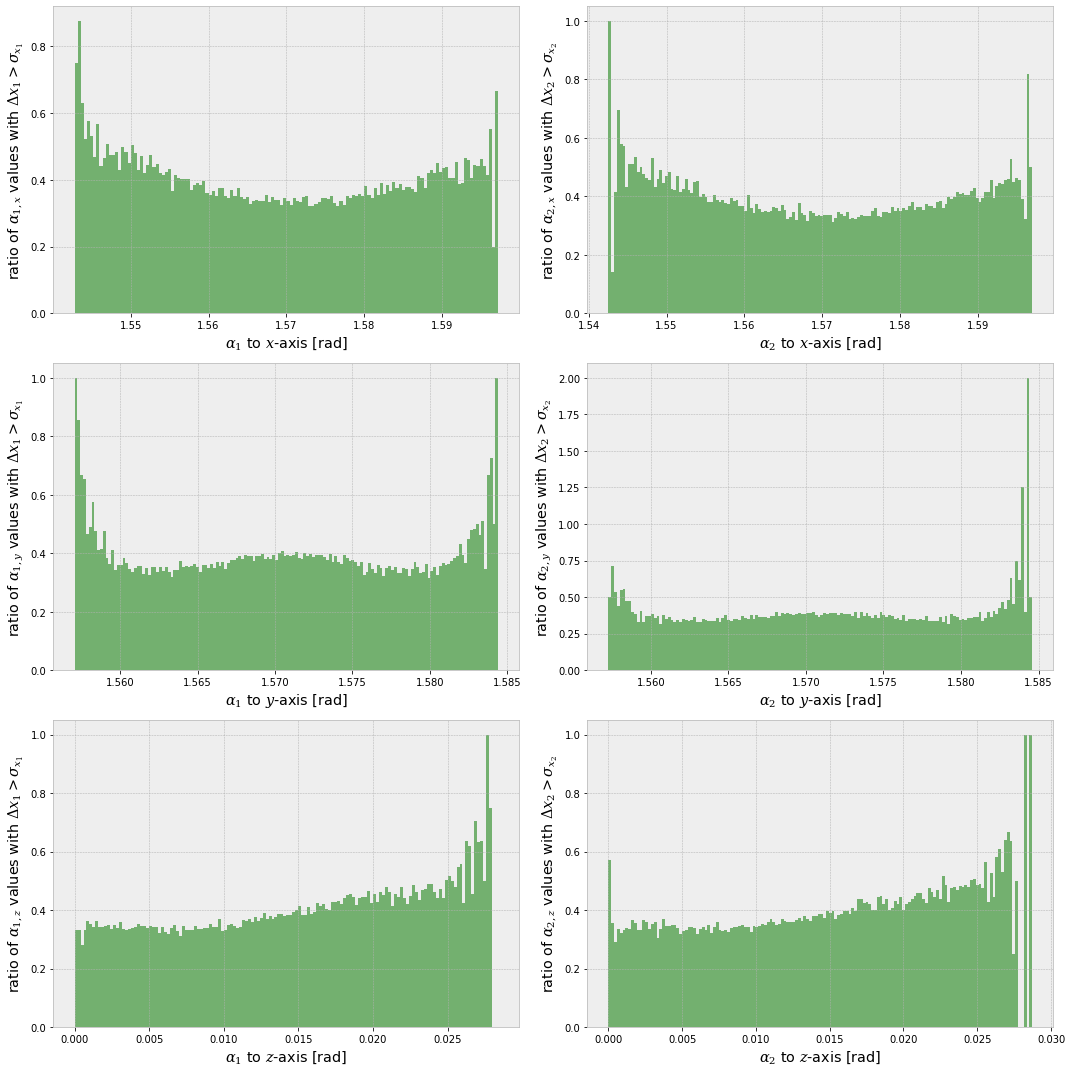

In [28]:
plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b, range=(1.54,1.60))
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_x1_bad], bins=b, range=(1.54,1.60))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_x1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b, range=(0,0.03))
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_x1_bad], bins=b, range=(0,0.03))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta x_{1} > \sigma_{x_{1}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_x2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_x2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_x2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta x_{2} > \sigma_{x_{2}} $")

plt.tight_layout()
plt.show()


/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/nfs/freenas/tuph/e18/project/compass/analysis/saumiller/ecal/python_NNenv/lib64/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


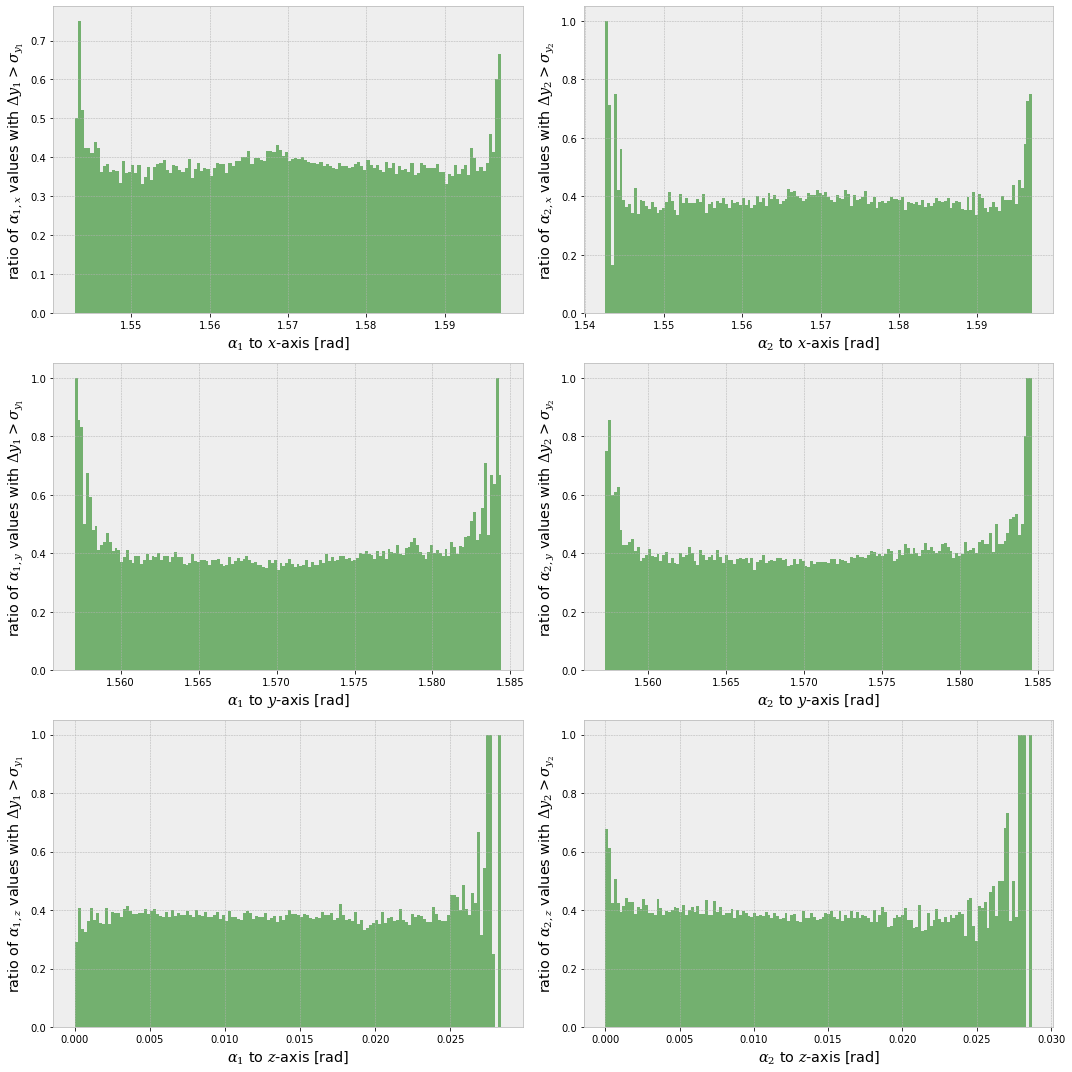

In [29]:

plt.rcParams["figure.figsize"] = (15, 15)

# plots mit Werten die mehr als 1 sigma von E1 abweichen
plt.subplot(3,2,1)
hist_E1_t, bin_E1_t = np.histogram(theta_x1_t, bins=b, range=(1.54,1.60))
hist_E1_bad, bins = np.histogram(theta_x1_t[ind_y1_bad], bins=b, range=(1.54,1.60))
plt.bar(bin_E1_t[:len(bin_E1_t)-1], hist_E1_bad/hist_E1_t, align='edge', width=bin_E1_t[1]-bin_E1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, x}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

plt.subplot(3,2,3)
hist_x1_t, bin_x1_t = np.histogram(theta_y1_t, bins=b)
hist_x1_bad, bins = np.histogram(theta_y1_t[ind_y1_bad], bins=b)
plt.bar(bin_x1_t[:len(bin_x1_t)-1], hist_x1_bad/hist_x1_t, align='edge', width=bin_x1_t[1]-bin_x1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, y}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

plt.subplot(3,2,5)
hist_y1_t, bin_y1_t = np.histogram(theta_z1_t, bins=b, range=(0,0.03))
hist_y1_bad, bins = np.histogram(theta_z1_t[ind_y1_bad], bins=b, range=(0,0.03))
plt.bar(bin_y1_t[:len(bin_y1_t)-1], hist_y1_bad/hist_y1_t, align='edge', width=bin_y1_t[1]-bin_y1_t[0]) 
plt.xlabel(r"$\alpha_1$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{1, z}$ values with $\Delta y_{1} > \sigma_{y_{1}} $")

# plots mit Werten die mehr als 1 sigma von E2 abweichen
plt.subplot(3,2,2)
hist_E2_t, bin_E2_t = np.histogram(theta_x2_t, bins=b)
hist_E2_bad, bins = np.histogram(theta_x2_t[ind_y2_bad], bins=b)
plt.bar(bin_E2_t[:len(bin_E2_t)-1], hist_E2_bad/hist_E2_t, align='edge', width=bin_E2_t[1]-bin_E2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $x$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, x}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.subplot(3,2,4)
hist_x2_t, bin_x2_t = np.histogram(theta_y2_t, bins=b)
hist_x2_bad, bins = np.histogram(theta_y2_t[ind_y2_bad], bins=b)
plt.bar(bin_x2_t[:len(bin_x2_t)-1], hist_x2_bad/hist_x2_t, align='edge', width=bin_x2_t[1]-bin_x2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $y$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, y}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.subplot(3,2,6)
hist_y2_t, bin_y2_t = np.histogram(theta_z2_t, bins=b)
hist_y2_bad, bins = np.histogram(theta_z2_t[ind_y2_bad], bins=b)
plt.bar(bin_y2_t[:len(bin_y2_t)-1], hist_y2_bad/hist_y2_t, align='edge', width=bin_y2_t[1]-bin_y2_t[0]) 
plt.xlabel(r"$\alpha_2$ to $z$-axis [rad]")
plt.ylabel(r"ratio of $\alpha_{2, z}$ values with $\Delta y_{2} > \sigma_{y_{2}} $")

plt.tight_layout()
plt.show()

